# Citation data

In [1]:
import dill
import copy
import json
import pandas as pd
import networkx as nx

from itertools import chain, chain, batched
from tqdm.auto import tqdm

from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers, Funders, config

config.email = "h.w.a.duijf@uu.nl"
config.max_retries = 5

# Empirical robustness

## Methods

### Prune citation data: only articles, and remove articles without bibliography

In [3]:
def get_works_with_references(works) -> list:
    works_pruned = []
    for work in works:
        try:
            assert work["referenced_works"] != []
            works_pruned.append(work)
        except:
            pass
    return works_pruned

In [4]:
def get_articles(works) -> list:
    articles = []
    for work in works:
        try:
            assert work["primary_location"]["source"]["type"] == "journal"
            assert work["type"] == "article"
            articles.append(work)
        except:
            pass
    return articles

### Create author network from dataframe of records

In [5]:
def create_author_network(works: list) -> nx.DiGraph:
    # Create a directed graph
    # Create dataframe
    df = pd.DataFrame(works)
    G = nx.DiGraph()


    # Add nodes and edges
    for ix,row in tqdm(df.iterrows()):
        for author in row['authorships']:
            this_author = author['author']['id'] 
            
            # ignore the author with the id "A9999999999" as it is a placeholder for missing values
            if this_author.split("/")[-1] == "A9999999999": 
                continue
            
            # add the author if not already present in the network
            if this_author not in G.nodes():
                G.add_node(this_author)
                # G.nodes()[this_author]['authored_paper_count'] = 1
                # G.nodes()[this_author]['cited_count'] = 0
                # G.nodes()[this_author]['titles'] = [row['title']]
            # else:
                # G.nodes()[this_author]['authored_paper_count'] += 1
                # G.nodes()[this_author]['titles'].append(row['title'])
            
            # add edges
            for cited_work_id in row["referenced_works"]:
                cited_work = df[df['id'] == cited_work_id] # This fails silently if citations are not present!
                if len(cited_work) >= 1: # In case of multiple hits (shouldn't happen once sampling is fixed)
                    cited_work = cited_work.iloc[0]
                    
                for cited_author in cited_work['authorships']:
                    cited_author = cited_author['author']['id'] 
                    
                    if cited_author not in G.nodes():
                        G.add_node(cited_author)
                        # G.nodes()[cited_author]['cited_count'] = 1
                        # G.nodes()[cited_author]['authored_paper_count'] = 0
                        # G.nodes()[cited_author]['titles'] = [cited_work['title']]
                    # else:
                        # G.nodes()[cited_author]['cited_count'] += 1
                        # G.nodes()[cited_author]['titles'].append(cited_work['title'])
                    
                    
                    if G.has_edge(cited_author, this_author):  # edges go FROM cited TO citing
                        pass
                    else:
                        G.add_edge(cited_author, this_author)
                            
    # # Optionally, you can print the nodes and edges to verify
    # print(f"{len(G.nodes())=:,}")
    # print(f"{len(G.edges())=:,}")
    return G

### Pruning by removing ‘twins’ (aka, strong co-authors)

In [6]:
def generate_twins_dict(net: nx.DiGraph, records: list) -> dict:
    
    authors_twins_dict = {}

    for author_id in tqdm(net.nodes()):
        author_records = [
            work for work in records 
            if author_id in [author["author"]["id"] for author in work["authorships"]]]
            
        for k, record in enumerate(author_records):
            if k == 0:
                coauthors = [
                    coauthor["author"]["id"] 
                    for coauthor in record["authorships"]
                    if coauthor["author"]["id"] != author_id
                ]
                twins = set(coauthors)
            elif twins == set():
                break
            else:
                coauthors = [
                    coauthor["author"]["id"] 
                    for coauthor in record["authorships"]
                    if coauthor["author"]["id"] != author_id
                ]
                twins = twins.intersection(set(coauthors))
        if twins:
            authors_twins_dict[author_id] = twins
    return authors_twins_dict

In [7]:
def prune_network(net: nx.DiGraph, authors_twins_dict: dict) -> nx.DiGraph:
    network_pruned = copy.deepcopy(net)
    for author_id, twins in tqdm(authors_twins_dict.items()):
        twins_in_network = [twin for twin in twins if twin in network_pruned.nodes()]
        if twins_in_network:
            network_pruned.remove_node(author_id)
    return network_pruned

### Pruning by taking the largest weakly connected component

In [8]:
def produce_lcc(net: nx.DiGraph) -> nx.DiGraph:
    # Extract largest component:
    largest_cc = max(nx.weakly_connected_components(net), key=len)
    lcc = copy.deepcopy(net.subgraph(largest_cc))
    return lcc

In [9]:
def remove_self_loops(net: nx.DiGraph) -> nx.DiGraph:
    network_pruned = copy.deepcopy(net).copy()
    for node in net.nodes():
        if (node, node) in net.edges():
            network_pruned.remove_edge(node, node)
    return network_pruned

## Citation data from OpenAlex

In [10]:
def get_works_from_OA(text: str, year: str) -> list:
    query = Works().search(text).filter(publication_year=year)
    works = []

    for i, work in enumerate(chain(*query.paginate(per_page=200, n_max=None))):
        works.append(work)
    print(f"{len(works)=:,}")
    return works

### Peptic ulcer disease

Get the records

In [36]:
works_pud = get_works_from_OA(text="peptic ulcer disease", year="1900-1978") 

len(works)=28,824


In [40]:
works_pud_pruned = get_works_with_references(works_pud)
print(f"{len(works_pud_pruned)=:,}")

len(works_pud_pruned)=14,939


In [41]:
articles_pud = get_articles(works_pud_pruned)
print(f"{len(articles_pud)=:,}")

len(articles_pud)=13,750


Create author-based network

In [42]:
network_pud_original = create_author_network(articles_pud) 
print(f"{network_pud_original.number_of_nodes()=:,}")
print(f"{network_pud_original.number_of_edges()=:,}")

0it [00:00, ?it/s]

network_pud_original.number_of_nodes()=19,378
network_pud_original.number_of_edges()=68,310


Prune author-based network

In [44]:
authors_twins_dict = generate_twins_dict(network_pud_original, works_pud)
network_pud_pruned = prune_network(network_pud_original, authors_twins_dict)
print(f"{network_pud_pruned.number_of_nodes()=:,}")
print(f"{network_pud_pruned.number_of_edges()=:,}")

network_pud_pruned_lcc = produce_lcc(network_pud_pruned)
print(f"{network_pud_pruned_lcc.number_of_nodes()=:,}")
print(f"{network_pud_pruned_lcc.number_of_edges()=:,}")

network_pud_final = remove_self_loops(network_pud_pruned_lcc)
print(f"{network_pud_final.number_of_nodes()=:,}")
print(f"{network_pud_final.number_of_edges()=:,}")

  0%|          | 0/19378 [00:00<?, ?it/s]

  0%|          | 0/12111 [00:00<?, ?it/s]

network_pud_pruned.number_of_nodes()=9,450
network_pud_pruned.number_of_edges()=23,149
network_pud_pruned_lcc.number_of_nodes()=5,493
network_pud_pruned_lcc.number_of_edges()=22,891
network_pud_final.number_of_nodes()=5,493
network_pud_final.number_of_edges()=22,159


Save networks

In [ ]:
with open ('data/pud_works.pkl', 'wb') as f:
    dill.dump(works_pud, f)

with open('data/pud_original.pkl', 'wb') as f:
    dill.dump(network_pud_original, f)

with open('data/pud_final.pkl', 'wb') as f:
    dill.dump(network_pud_final, f)

### Perceptron

In [11]:
works_perceptron = get_works_from_OA(text="perceptron", year="1900-2000") 

len(works)=13,634


In [14]:
works_perceptron_pruned = get_works_with_references(works_perceptron)
print(f"{len(works_perceptron_pruned)=:,}")

len(works_perceptron_pruned)=9,839


In [15]:
articles_perceptron = get_articles(works_perceptron_pruned)
print(f"{len(articles_perceptron)=:,}")

len(articles_perceptron)=7,667


Create author-based network

In [16]:
network_perceptron_original = create_author_network(articles_perceptron) 
print(f"{network_perceptron_original.number_of_nodes()=:,}")
print(f"{network_perceptron_original.number_of_edges()=:,}")

0it [00:00, ?it/s]

network_perceptron_original.number_of_nodes()=12,675
network_perceptron_original.number_of_edges()=69,737


Prune author-based network

In [17]:
authors_twins_dict = generate_twins_dict(network_perceptron_original, articles_perceptron)
network_perceptron_pruned = prune_network(network_perceptron_original, authors_twins_dict)
print(f"{network_perceptron_pruned.number_of_nodes()=:,}")
print(f"{network_perceptron_pruned.number_of_edges()=:,}")

network_perceptron_pruned_lcc = produce_lcc(network_perceptron_pruned)
print(f"{network_perceptron_pruned_lcc.number_of_nodes()=:,}")
print(f"{network_perceptron_pruned_lcc.number_of_edges()=:,}")

network_perceptron_final = remove_self_loops(network_perceptron_pruned_lcc)
print(f"{network_perceptron_final.number_of_nodes()=:,}")
print(f"{network_perceptron_final.number_of_edges()=:,}")

  0%|          | 0/12675 [00:00<?, ?it/s]

  0%|          | 0/10325 [00:00<?, ?it/s]

network_perceptron_pruned.number_of_nodes()=4,306
network_perceptron_pruned.number_of_edges()=19,925
network_perceptron_pruned_lcc.number_of_nodes()=3,175
network_perceptron_pruned_lcc.number_of_edges()=19,852
network_perceptron_final.number_of_nodes()=3,175
network_perceptron_final.number_of_edges()=18,907


Save networks

In [46]:
with open('data/perceptron_works.pkl', 'wb') as f:
    dill.dump(works_perceptron, f)

with open('data/perceptron_original.pkl', 'wb') as f:
    dill.dump(network_perceptron_original, f)
    
with open('data/perceptron_final.pkl', 'wb') as f:
    dill.dump(network_perceptron_final, f)

# Variation methods


Main contribution of the paper:

- Methodological contribution of empirical robustness for _network_ epistemology. 

Key challenge:

- Test whether inequality (or some other network feature such as density, clustering, or diameter) increases reliability (or some other metric such as speed).
- Counterfactual: had the network been more equal, the group would have been more reliable.
- This requires us to identify networks that differ in their inequality but are otherwise maximally similar.
- We consider three network features: density, clustering, and degree inequality. So networks that have the similar density, clustering and degree inequality are considered maximally similar. (I left out diameter here.)

To achieve this, we develop some variation methods. The main goals for these variation methods are:

1. Control: Ability to tinker with specific network features (density, inequality, clustering)
2. Simplicity
3. Computational tractability
4. Link to (individualistic) intervention 

There are two types of variation methods: 

1. Possibly complex variation methods that can be used to produce networks with specific network properties (density, inequality, clustering), i.e., high control
2. Intuitive and simple variation methods that yield a lower degree of control over the specific network properties (density, inequality, clustering)

The basic ideas in these variation methods are the following:

1. Density
    - Increase by adding edges
    - Keep constant by rewiring edges
    - Decrease by removing edges [not implemented]
2. Clustering
    - Note: the local clustering coefficient of a given node basically is the number of triangles that pass by that node divided by the number of possible triangles that pass by that node. 
    - Increase by adding edges that create new triangles
    - Keep constant ???
    - Decrease by removing edges from existing triangles
3. Inequality
    - Decrease by adding edges randomly (following the uniform degree distribution)
    - Keep constant by adding edges following the original degree distribution (i.e., that of the PUD network)
    - Increase by (a) sequentially adding edges preferentially, or  (b) by adding edges following a degree distribution that is more unequal than the original one [neither implemented]

## Hop over to Outcomes section to see the results of the different variation methods

## Simple variation methods

### Equalizers: tinker with inequality

1. `randomize_network`: Randomly rewire edges (following the uniform degree distribution) [THIS IS WHAT WE CURRENTLY DO]
    - Density $=$
    - Clustering $\downarrow$
    - Inequality $\downarrow$
2. `equalize`: Rewire triangles: Take a triangle, take a node in the triangle, remove the edge in the triangle that does not contain the node, then add a random new edge that creates a new triangle that passed by the node. (The goal was to keep clustering somewhat equal, while increasing equality.)
    - Density $=$
    - Clustering $\approx \downarrow$
    - Inequality $\downarrow$

### Densify
1. [not implemented] Randomly add edges (following the uniform degree distribution)
    - Expectations
        - Density $\uparrow$
        - Clustering $\downarrow$
        - Inequality $\downarrow$
2. `densify`: Add edges following the original degree distribution
    - Density $\uparrow$
    - Clustering $\downarrow$
    - Inequality $=$
3. `cluster`: Add edges that create new triangles (taking into account the original degree distribution)
    - Density $\uparrow$
    - Clustering $\Uparrow$
    - Inequality $\approx$ 

### Clustering
1. `decluster`: Remove edges from existing triangles and add new edge following the original degree distribution
    - Density $=$
    - Clustering $\Downarrow$
    - Inequality $\approx\downarrow$


## Complex variation methods

1. `densify_fancy`: Add edges in such a way to attempt to reach a target clustering coefficient and a target degree distribution (original or uniform). 
    - Basically, the algorithm checks whether the target clustering coefficient has been reached. If not, it adds an edge that increases clustering. If yes, it adds a new edge following the target degree distribution. 
    - **Computationally costly**: after an edge is added, the algorithm calculates the clustering coefficient of the new network, which is computationally costly. 
    - **High degree of control**, especially regarding the clustering coefficient: For example, can be used to achieve the following:
        1. Only increase density
            - Density $\uparrow$
            - Clustering $=$
            - Inequality $=$
        2. Increase density and decrease inequality
            - Density $\uparrow$
            - Clustering $=$
            - Inequality $\downarrow$
2. `densify_semi_fancy`: Add edges either to increase clustering or following the target degree distribution — with a fixed probability.
    - Basically, the algorithm throws a (biased) coin to determine whether it will add an edge that increases clustering or add one following the target degree distribution. 
    - Computationally fast. Relies on a biased coin toss instead of calculating the clustering coefficient. The drawback is that the clustering coefficient will change to some degree.
    - Pretty high degree of control.

- Note: we could keep the density fixed by first removing a number of edges and then using `densify_fancy` or `densify_semi_fancy` to add the same number of edges. 

## Thoughts and observations

- I was surprised to learn that both the in-degree and the out-degree distributions of the PUD network are scale free. However, they are not neatly correlated. Nonetheless, my suspicion is that there is a pattern between an agent’s number of publication and both its in-degree and its out-degree. 
- I was surprised to learn that the clustering coefficient is not based on directed graphs (`nx.average_clustering`). 
- In a sense, we have currently only implemented the target degree distribution of the degree distribution of the input network (the PUD network) or the uniform distribution. We could consider other degree distributions (i.e., an unequal distribution that flips the original degree distribution)
- 


## Setup

In [1]:
import random as rd
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx

import dill 
import copy

network_pud: nx.DiGraph = dill.load(open('data/pud_final.pkl', 'rb'))

In [2]:
def calculate_degree_gini(G, directed = True):
    if directed:
        degrees = [deg for _, deg in G.out_degree()]
    else:
        degrees = [deg for _, deg in G.degree()]
    # Sort the degrees in ascending order
    sorted_x = np.sort(np.array(degrees))
    n = len(np.array(degrees))
    cumx = np.cumsum(sorted_x, dtype=float)
    gini = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

    return gini

In [3]:
def get_triangles(net: nx.DiGraph):
    """Return the list of all triangles in a directed graph G."""
    triangles = []
    for clique in nx.enumerate_all_cliques(net.to_undirected()):
        if len(clique) <= 3:
            if len(clique) == 3:
                triangles.append(clique)
        else:
            return triangles
    return triangles

## Randomize

In [4]:
def randomize_network(G, p_rewiring):
    # Check if the graph is directed
    is_directed = G.is_directed()

    # Get edges and nodes
    edges = list(G.edges()).copy()
    rd.shuffle(edges)
    edges_set = set(edges)
    new_edges_set = edges_set.copy()
    nodes = list(G.nodes()).copy()

    # Find which edges to remove
    to_remove_set = set()
    for old_edge in edges:
        if rd.random() < p_rewiring:  # p probability to rewire an edge
            to_remove_set.add(old_edge)
            new_edges_set.remove(old_edge)

    # Generate a new edges
    for edge in to_remove_set:
        new_edge = (rd.choice(nodes), rd.choice(nodes))
        if not is_directed:
            new_edge = tuple(sorted(new_edge))  # Ensure (u, v) == (v, u) for undirected graphs

        # Avoid duplicate edges and self-loops
        while (new_edge in new_edges_set) or (new_edge[0] == new_edge[1]):
            new_edge = (rd.choice(nodes), rd.choice(nodes))
            if not is_directed:
                new_edge = tuple(sorted(new_edge))

        new_edges_set.add(new_edge)

    # Create a new graph with updated edges
    G_new = G.copy()
    G_new.remove_edges_from(to_remove_set)
    G_new.add_edges_from(new_edges_set)

    return G_new

In [5]:
random_net_1 = randomize_network(network_pud, p_rewiring=0.1)
random_net_2 = randomize_network(network_pud, p_rewiring=0.2)
random_net_3 = randomize_network(network_pud, p_rewiring=0.3)
random_net_4 = randomize_network(network_pud, p_rewiring=0.4)
random_net_5 = randomize_network(network_pud, p_rewiring=0.5)

In [6]:
data_random = {
    "network": ["original", "random_10%", "random_20%", "random_30%", "random_40%", "random_50%"],
    "degree_gini": [
        calculate_degree_gini(network_pud, directed=True),
        calculate_degree_gini(random_net_1, directed=True),
        calculate_degree_gini(random_net_2, directed=True),
        calculate_degree_gini(random_net_3, directed=True),
        calculate_degree_gini(random_net_4, directed=True),
        calculate_degree_gini(random_net_5, directed=True)
    ],
    "clustering_coefficient": [
        nx.average_clustering(network_pud),
        nx.average_clustering(random_net_1),
        nx.average_clustering(random_net_2),
        nx.average_clustering(random_net_3),
        nx.average_clustering(random_net_4),
        nx.average_clustering(random_net_5)
    ],
    "density": [
        nx.density(network_pud),
        nx.density(random_net_1),
        nx.density(random_net_2),
        nx.density(random_net_3),
        nx.density(random_net_4),
        nx.density(random_net_5)
    ]
}
df_random = pd.DataFrame(data_random)
df_random


,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,random_10%,0.667807,0.073223,0.000735
2,random_20%,0.614755,0.048130,0.000735
3,random_30%,0.563860,0.031551,0.000735
4,random_40%,0.512527,0.019826,0.000735
5,random_50%,0.457553,0.011515,0.000735


## Equalize

In [7]:
def equalize(net: nx.DiGraph, n: int) -> nx.DiGraph:
    """
    Equalize the network by rewiring n random edges.
    """
    equalized_net = copy.deepcopy(net)
    triangles = get_triangles(net)
    rewired_triangles = rd.sample(triangles, n)
    
    for triangle in rewired_triangles:
        edge = triangle[-2:]  # Take the last two nodes as the edge to be rewired
        # Remove edge
        if equalized_net.has_edge(*edge):
            equalized_net.remove_edge(*edge)
        elif equalized_net.has_edge(edge[1], edge[0]):
            equalized_net.remove_edge(edge[1], edge[0]) 
        else:
            continue
        
        # Add new edge to create a new triangle that passes by the first node
        node = triangle[0] 
        neighbors = list(net.predecessors(node)) + list(net.successors(node))

        sources_sample = rd.choices(neighbors, k=10)
        targets_sample = rd.choices(neighbors, k=10)
        edge_sample = [
            (source, target) 
            for source in sources_sample 
            for target in targets_sample 
            if source != target and not equalized_net.has_edge(source, target)]
        new_edge = rd.choice(edge_sample) # Throws an error if no edges are available
        equalized_net.add_edge(*new_edge)
    return equalized_net

In [8]:
equalized_net_1 = equalize(network_pud, n=1000)
equalized_net_2 = equalize(network_pud, n=2000)
equalized_net_3 = equalize(network_pud, n=3000)
equalized_net_4 = equalize(network_pud, n=4000)
equalized_net_5 = equalize(network_pud, n=5000)


In [9]:
data_equalize = {
    "network": ["original", "equalized_1000", "equalized_2000", "equalized_3000", "equalized_4000", "equalized_5000"],
    "degree_gini": [
        calculate_degree_gini(network_pud, directed=True),
        calculate_degree_gini(equalized_net_1, directed=True),
        calculate_degree_gini(equalized_net_2, directed=True),
        calculate_degree_gini(equalized_net_3, directed=True),
        calculate_degree_gini(equalized_net_4, directed=True),
        calculate_degree_gini(equalized_net_5, directed=True)
    ],
    "clustering_coefficient": [
        nx.average_clustering(network_pud),
        nx.average_clustering(equalized_net_1),
        nx.average_clustering(equalized_net_2),
        nx.average_clustering(equalized_net_3),
        nx.average_clustering(equalized_net_4),
        nx.average_clustering(equalized_net_5)
    ],
    "density": [
        nx.density(network_pud),
        nx.density(equalized_net_1),
        nx.density(equalized_net_2),
        nx.density(equalized_net_3),
        nx.density(equalized_net_4),
        nx.density(equalized_net_5)
    ]
}

df_equalize = pd.DataFrame(data_equalize)
df_equalize

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,equalized_1000,0.711385,0.109158,0.000735
2,equalized_2000,0.704843,0.103485,0.000735
3,equalized_3000,0.696477,0.099182,0.000735
4,equalized_4000,0.691001,0.092230,0.000735
5,equalized_5000,0.684937,0.091519,0.000735


## Densify

In [21]:
def densify_network(net: nx.DiGraph, n_edges: int) -> nx.DiGraph:
    # Create a copy of the original network
    densified_net = copy.deepcopy(net)
    
    # Get the degree distribution
    in_degrees = dict(net.in_degree())
    out_degrees = dict(net.out_degree())
    multiplier = 10
    targets = rd.choices(
        list(in_degrees.keys()), 
        weights=list(in_degrees.values()), 
        k=multiplier*n_edges
    )
    sources = rd.choices(
        list(out_degrees.keys()), 
        weights=out_degrees.values(), 
        k=multiplier*n_edges
    )

    edges_new = list(set(zip(sources, targets))) 
    edges_new = [edge for edge in edges_new if edge[0] != edge[1]]  
    edges_new = [edge for edge in edges_new if not edge in net.edges()]
    edges_new = edges_new[:n_edges] 
    
    densified_net.add_edges_from(edges_new)
    return densified_net

In [22]:
densify_net_1 = densify_network(network_pud, n_edges=1000)
print("Done")
densify_net_2 = densify_network(network_pud, n_edges=2000)
print("Done")
densify_net_3 = densify_network(network_pud, n_edges=3000)
print("Done")
densify_net_4 = densify_network(network_pud, n_edges=4000)
print("Done")
densify_net_5 = densify_network(network_pud, n_edges=5000)
print("Done")

Done
Done
Done
Done
Done


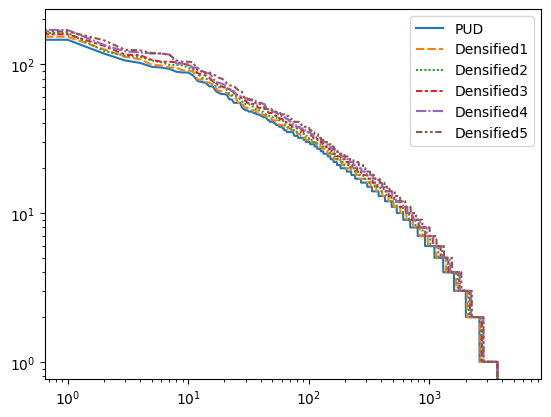

In [23]:
out_degrees_pud = sorted(list(dict(network_pud.out_degree()).values()), reverse=True)

out_degrees_densify_1 = sorted(list(dict(densify_net_1.out_degree()).values()), reverse=True)
out_degrees_densify_2 = sorted(list(dict(densify_net_2.out_degree()).values()), reverse=True)
out_degrees_densify_3 = sorted(list(dict(densify_net_3.out_degree()).values()), reverse=True)
out_degrees_densify_4 = sorted(list(dict(densify_net_4.out_degree()).values()), reverse=True)
out_degrees_densify_5 = sorted(list(dict(densify_net_5.out_degree()).values()), reverse=True)

data = zip(
    out_degrees_pud, 
    out_degrees_densify_1, out_degrees_densify_2, out_degrees_densify_3, out_degrees_densify_4, out_degrees_densify_5)

df = pd.DataFrame(data, columns=["PUD", "Densified1", "Densified2", "Densified3", "Densified4", "Densified5"])

fig = sns.lineplot(df)
fig.set_yscale("log")
fig.set_xscale("log")


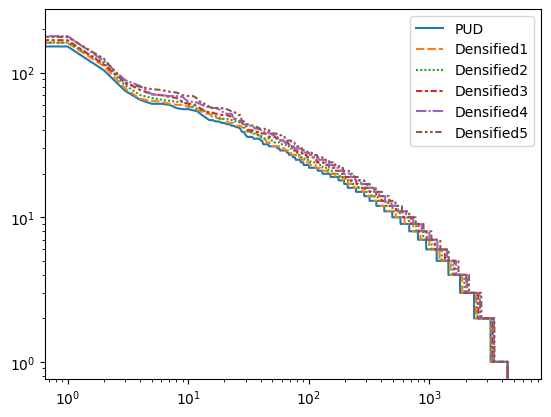

In [24]:
in_degrees_pud = sorted(list(dict(network_pud.in_degree()).values()), reverse=True)

in_degrees_densify_1 = sorted(list(dict(densify_net_1.in_degree()).values()), reverse=True)
in_degrees_densify_2 = sorted(list(dict(densify_net_2.in_degree()).values()), reverse=True)
in_degrees_densify_3 = sorted(list(dict(densify_net_3.in_degree()).values()), reverse=True)
in_degrees_densify_4 = sorted(list(dict(densify_net_4.in_degree()).values()), reverse=True)
in_degrees_densify_5 = sorted(list(dict(densify_net_5.in_degree()).values()), reverse=True)

data = zip(
    in_degrees_pud, 
    in_degrees_densify_1, in_degrees_densify_2, in_degrees_densify_3, in_degrees_densify_4, in_degrees_densify_5)

df = pd.DataFrame(data, columns=["PUD", "Densified1", "Densified2", "Densified3", "Densified4", "Densified5"])

fig = sns.lineplot(df)
fig.set_yscale("log")
fig.set_xscale("log")


In [26]:
data_densify = {
    "network": ["original", "densified_1000", "densified_2000", "densified_3000", "densified_4000", "densified_5000"],
    "degree_gini": [
        calculate_degree_gini(network_pud, directed=True),
        calculate_degree_gini(densify_net_1, directed=True),
        calculate_degree_gini(densify_net_2, directed=True),
        calculate_degree_gini(densify_net_3, directed=True),
        calculate_degree_gini(densify_net_4, directed=True),
        calculate_degree_gini(densify_net_5, directed=True)
    ],
    "clustering_coefficient": [
        nx.average_clustering(network_pud),
        nx.average_clustering(densify_net_1),
        nx.average_clustering(densify_net_2),
        nx.average_clustering(densify_net_3),
        nx.average_clustering(densify_net_4),
        nx.average_clustering(densify_net_5)
    ],
    "density": [
        nx.density(network_pud),
        nx.density(densify_net_1),
        nx.density(densify_net_2),
        nx.density(densify_net_3),
        nx.density(densify_net_4),
        nx.density(densify_net_5)
    ]
}

df_densify = pd.DataFrame(data_densify)
df_densify

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,densified_1000,0.724036,0.108905,0.000768
2,densified_2000,0.724389,0.103441,0.000801
3,densified_3000,0.725306,0.097599,0.000834
4,densified_4000,0.726425,0.091955,0.000867
5,densified_5000,0.727128,0.085695,0.000900


In [28]:
def densify_semi_fancy(
    net: nx.DiGraph, n_edges: int, p_increase_clustering: float, target_degree_dist: str = "original",
) -> nx.DiGraph:
    """
    Densifies a directed network by adding new edges, balancing between increasing 
    ing
    and preserving a target degree distribution.

    Parameters
    ----------
    net : nx.DiGraph
        The original directed network to densify.
    n_edges : int
        The number of new edges to add.
    p_increase_clustering : float
        Probability (between 0 and 1) that a new edge is added to increase clustering
        (i.e., create new triangles). Otherwise, new edges are added based on the 
        target degree distribution.
    target_degree_dist : str, optional
        The target degree distribution for new edges.
        "original" uses the original network's degree distribution,
        "uniform" assigns equal probability to all nodes. Default is "original".

    Returns
    -------
    nx.DiGraph
        A new directed network with additional edges.
    """
    
    # Create a copy of the original network
    net_new = copy.deepcopy(net)
    
    if target_degree_dist == "original":
        # Use the original degree distribution
        out_degrees = dict(net.out_degree())
        in_degrees = dict(net.in_degree())
    if target_degree_dist == "uniform":
        out_degrees = {node: 1 for node in net.nodes()}
        in_degrees = {node: 1 for node in net.nodes()}

    # Add edges in neighborhoods
    n_edges_added = 0
    edges_added_clustering = 0
    edges_added_degree_dist = 0
    while n_edges_added < n_edges:
        if rd.random() < p_increase_clustering:
            # Add new edge to increase clustering
            possible_edges = []
            while possible_edges == []:
                node = rd.choice(list(net.nodes()))
                neighbors = list(net.predecessors(node)) + list(net.successors(node))
                out_degrees_neighbors = {node: out_degrees[node] for node in neighbors}
                in_degrees_neighbors = {node: in_degrees[node] for node in neighbors}
                out_weights = out_degrees_neighbors.values()
                if all(out_weights) == 0:
                    out_weights = np.ones(len(out_degrees_neighbors.keys()))
                
                in_weights = in_degrees_neighbors.values()
                if all(in_weights) == 0:
                    in_weights = np.ones(len(in_degrees_neighbors.keys()))
                
                sources = rd.choices(list(out_degrees_neighbors.keys()), weights=out_weights, k=10)
                targets = rd.choices(list(in_degrees_neighbors.keys()), weights=in_weights, k=10)
                possible_edges = [
                    (source, target) for source in sources for target in targets
                    if source != target and not net_new.in_edges(source, target)
                ]
                if possible_edges != []:
                    new_edge = rd.choice(possible_edges)
                    n_edges_added += 1
                    net_new.add_edge(*new_edge)
                    edges_added_clustering += 1
        else:
            # Add new edge based on target degree distribution
            edge_sample = []
            while edge_sample == []:
                sources_sample = rd.choices(list(out_degrees.keys()), weights=out_degrees.values(), k=10)
                targets_sample = rd.choices(list(in_degrees.keys()), weights=in_degrees.values(), k=10)
                edge_sample = [
                    (source, target) 
                    for source in sources_sample 
                    for target in targets_sample 
                    if source != target and not net_new.has_edge(source, target)]
                if edge_sample != []:
                    new_edge = rd.choice(edge_sample) # Throws an error if no edges are available
                    n_edges_added += 1
                    net_new.add_edge(*new_edge)
                    edges_added_degree_dist += 1
        # print(f"{n_edges_added=:,} edges added")
    print(f"{edges_added_clustering:,} edges added to increase clustering")
    print(f"{edges_added_degree_dist:,} edges added based on {target_degree_dist} degree distribution")
    return net_new

In [48]:
p_increase_clustering = 0.33

densify_semi_1 = densify_semi_fancy(
    network_pud, n_edges=1000, p_increase_clustering=p_increase_clustering, target_degree_dist="uniform",
)
densify_semi_2 = densify_semi_fancy(
    network_pud, n_edges=2000, p_increase_clustering=p_increase_clustering, target_degree_dist="uniform",
)
densify_semi_3 = densify_semi_fancy(
    network_pud, n_edges=3000, p_increase_clustering=p_increase_clustering, target_degree_dist="uniform",
)
densify_semi_4 = densify_semi_fancy(
    network_pud, n_edges=4000, p_increase_clustering=p_increase_clustering, target_degree_dist="uniform",
)
densify_semi_5 = densify_semi_fancy(
    network_pud, n_edges=5000, p_increase_clustering=p_increase_clustering, target_degree_dist="uniform",
)

308 edges added to increase clustering
692 edges added based on uniform degree distribution
680 edges added to increase clustering
1,320 edges added based on uniform degree distribution
982 edges added to increase clustering
2,018 edges added based on uniform degree distribution
1,294 edges added to increase clustering
2,706 edges added based on uniform degree distribution
1,617 edges added to increase clustering
3,383 edges added based on uniform degree distribution


In [49]:
data_densify_semi = {
    "network": [
        "original", 
        "densified_semi_fancy_1000", 
        "densified_semi_fancy_2000", 
        "densified_semi_fancy_3000", 
        "densified_semi_fancy_4000", 
        "densified_semi_fancy_5000"
    ],
    "degree_gini": [
        calculate_degree_gini(network_pud, directed=True),
        calculate_degree_gini(densify_semi_1, directed=True),
        calculate_degree_gini(densify_semi_2, directed=True),
        calculate_degree_gini(densify_semi_3, directed=True),
        calculate_degree_gini(densify_semi_4, directed=True),
        calculate_degree_gini(densify_semi_5, directed=True)
    ],
    "clustering_coefficient": [
        nx.average_clustering(network_pud),
        nx.average_clustering(densify_semi_1),
        nx.average_clustering(densify_semi_2),
        nx.average_clustering(densify_semi_3),
        nx.average_clustering(densify_semi_4),
        nx.average_clustering(densify_semi_5)
    ],
    "density": [
        nx.density(network_pud),
        nx.density(densify_semi_1),
        nx.density(densify_semi_2),
        nx.density(densify_semi_3),
        nx.density(densify_semi_4),
        nx.density(densify_semi_5)
    ]
}

df_densify_semi = pd.DataFrame(data_densify_semi)
df_densify_semi

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,densified_semi_fancy_1000,0.704892,0.119199,0.000766
2,densified_semi_fancy_2000,0.685972,0.119360,0.000796
3,densified_semi_fancy_3000,0.670087,0.115831,0.000827
4,densified_semi_fancy_4000,0.650645,0.109591,0.000856
5,densified_semi_fancy_5000,0.636777,0.103763,0.000884


In [51]:
def densify_fancy(
    net: nx.DiGraph, n_edges: int, target_degree_dist: str = "original", target_clustering: float = None,
) -> nx.DiGraph:
    """
    Densifies a directed network by adding new edges to increase its density, 
    while optionally targeting a specific degree distribution and clustering coefficient.
    Priority is given to targeting the specified clustering coefficient.

    Parameters
    ----------
    net : nx.DiGraph
        The original directed network to densify.
    n_edges : int
        The number of edges to add.
    target_degree_dist : str, optional
        The target degree distribution for new edges. 
        "original" preserves the original degree distribution, 
        "uniform" assigns equal probability to all nodes. Default is "original".
    target_clustering : float, optional
        The desired average clustering coefficient. If None, uses the original network's clustering.

    Returns
    -------
    nx.DiGraph
        A new directed network with increased density and optionally modified clustering/degree distribution.
    """
    
    # Create a copy of the original network
    net_new = copy.deepcopy(net)
    
    if target_clustering is None:
        target_clustering = nx.average_clustering(net)
    if target_degree_dist == "original":
        # Use the original degree distribution
        out_degrees = dict(net.out_degree())
        in_degrees = dict(net.in_degree())
    if target_degree_dist == "uniform":
        out_degrees = {node: 1 for node in net.nodes()}
        in_degrees = {node: 1 for node in net.nodes()}

    # Add edges in neighborhoods
    n_edges_added = 0
    edges_added_clustering = 0
    edges_added_degree_dist = 0
    new_clustering = nx.average_clustering(net_new)
    while n_edges_added < n_edges:
        if new_clustering < target_clustering:
            # Add new edge to increase clustering
            node = rd.choice(list(net.nodes()))
            neighbors = list(net.predecessors(node)) + list(net.successors(node))
            out_degrees_neighbors = {node: out_degrees[node] for node in neighbors}
            in_degrees_neighbors = {node: in_degrees[node] for node in neighbors}
            out_weights = out_degrees_neighbors.values()
            if all(out_weights) == 0:
                out_weights = np.ones(len(out_degrees_neighbors.keys()))
            in_weights = in_degrees_neighbors.values()
        
            if all(in_weights) == 0:
                in_weights = np.ones(len(in_degrees_neighbors.keys()))
            
            sources = rd.choices(list(out_degrees_neighbors.keys()), weights=out_weights, k=10)
            targets = rd.choices(list(in_degrees_neighbors.keys()), weights=in_weights, k=10)
            possible_edges = [
                (source, target) for source in sources for target in targets
                if source != target and not net_new.in_edges(source, target)
            ]
            if possible_edges != []:
                new_edge = rd.choice(possible_edges)
                n_edges_added += 1
                net_new.add_edge(*new_edge)
                new_clustering = nx.average_clustering(net_new)
                edges_added_clustering += 1
        else:
            # Add new edge based on target degree distribution
            sources_sample = rd.choices(list(out_degrees.keys()), weights=out_degrees.values(), k=10)
            targets_sample = rd.choices(list(in_degrees.keys()), weights=in_degrees.values(), k=10)
            edge_sample = [
                (source, target) 
                for source in sources_sample 
                for target in targets_sample 
                if source != target and not net_new.has_edge(source, target)]
            if edge_sample != []:
                new_edge = rd.choice(edge_sample) # Throws an error if no edges are available
                n_edges_added += 1
                net_new.add_edge(*new_edge)
                new_clustering = nx.average_clustering(net_new)
                edges_added_degree_dist += 1
        print(f"{n_edges_added=:,} edges added")
    print(f"{edges_added_clustering:,} edges added to increase clustering")
    print(f"{edges_added_degree_dist:,} edges added based on {target_degree_dist} degree distribution")
    return net_new

In [ ]:
densify_fancy_01 = densify_fancy(network_pud, n_edges=100, target_degree_dist="uniform") # Approx 25 seconds

n_edges_added=1 edges added
n_edges_added=2 edges added
n_edges_added=3 edges added
n_edges_added=3 edges added
n_edges_added=4 edges added
n_edges_added=5 edges added
n_edges_added=6 edges added
n_edges_added=7 edges added
n_edges_added=8 edges added
n_edges_added=9 edges added
n_edges_added=9 edges added
n_edges_added=9 edges added
n_edges_added=9 edges added
n_edges_added=9 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_added=10 edges added
n_edges_added=11 edges added
n_edges_added=12 edges added
n_edges_added=13 edges added
n_edges_added=14 edges added
n_edges_added=15 edges added
n_edges_added=16 edges added
n_edges_added=16 edges added
n_edges_added=16 edges added
n_edges_added=16 edges added
n_edges_added=17 edges added
n_edges_added=17 edges added
n_edges_added=17 edges added

In [54]:
densify_fancy_05 = densify_fancy(network_pud, n_edges=500, target_degree_dist="uniform") # Approx 2 minutes

n_edges_added=1 edges added
n_edges_added=2 edges added
n_edges_added=2 edges added
n_edges_added=2 edges added
n_edges_added=2 edges added
n_edges_added=2 edges added
n_edges_added=2 edges added
n_edges_added=2 edges added
n_edges_added=2 edges added
n_edges_added=2 edges added
n_edges_added=3 edges added
n_edges_added=3 edges added
n_edges_added=4 edges added
n_edges_added=5 edges added
n_edges_added=6 edges added
n_edges_added=7 edges added
n_edges_added=8 edges added
n_edges_added=9 edges added
n_edges_added=10 edges added
n_edges_added=11 edges added
n_edges_added=11 edges added
n_edges_added=11 edges added
n_edges_added=11 edges added
n_edges_added=12 edges added
n_edges_added=13 edges added
n_edges_added=14 edges added
n_edges_added=15 edges added
n_edges_added=16 edges added
n_edges_added=17 edges added
n_edges_added=18 edges added
n_edges_added=19 edges added
n_edges_added=20 edges added
n_edges_added=21 edges added
n_edges_added=22 edges added
n_edges_added=23 edges added
n_e

In [ ]:
densify_fancy_1 = densify_fancy(network_pud, n_edges=1000, target_degree_dist="uniform") # Approx 4:15 minutes

n_edges_added=1 edges added
n_edges_added=1 edges added
n_edges_added=2 edges added
n_edges_added=3 edges added
n_edges_added=4 edges added
n_edges_added=5 edges added
n_edges_added=6 edges added
n_edges_added=7 edges added
n_edges_added=7 edges added
n_edges_added=7 edges added
n_edges_added=7 edges added
n_edges_added=7 edges added
n_edges_added=8 edges added
n_edges_added=9 edges added
n_edges_added=10 edges added
n_edges_added=11 edges added
n_edges_added=11 edges added
n_edges_added=11 edges added
n_edges_added=11 edges added
n_edges_added=11 edges added
n_edges_added=12 edges added
n_edges_added=13 edges added
n_edges_added=13 edges added
n_edges_added=14 edges added
n_edges_added=15 edges added
n_edges_added=16 edges added
n_edges_added=17 edges added
n_edges_added=18 edges added
n_edges_added=19 edges added
n_edges_added=20 edges added
n_edges_added=21 edges added
n_edges_added=22 edges added
n_edges_added=23 edges added
n_edges_added=24 edges added
n_edges_added=25 edges added

In [57]:
data_densify_fancy = {
    "network": ["original", "densify_fancy_0100", "densify_fancy_0500", "densify_fancy_1000"], #, "cluster_constant_2", "cluster_constant_3", "cluster_constant_4", "cluster_constant_5"],
    "degree_gini": [
        calculate_degree_gini(network_pud, directed=True),
        calculate_degree_gini(densify_fancy_01, directed=True),
        calculate_degree_gini(densify_fancy_05, directed=True),
        calculate_degree_gini(densify_fancy_1, directed=True)
    ],
    "clustering_coefficient": [
        nx.average_clustering(network_pud),
        nx.average_clustering(densify_fancy_01),
        nx.average_clustering(densify_fancy_05),
        nx.average_clustering(densify_fancy_1)
    ],
    "density": [
        nx.density(network_pud),
        nx.density(densify_fancy_01),
        nx.density(densify_fancy_05),
        nx.density(densify_fancy_1)
    ]
}

df_densify_fancy = pd.DataFrame(data_densify_fancy)
df_densify_fancy

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,densify_fancy_0100,0.720931,0.117200,0.000738
2,densify_fancy_0500,0.712495,0.117172,0.000750
3,densify_fancy_1000,0.703496,0.117113,0.000766


## Cluster

In [10]:
def get_triangles(G: nx.DiGraph):
    """Return the list of all triangles in a directed graph G."""
    triangles = []
    for clique in nx.enumerate_all_cliques(G.to_undirected()):
        if len(clique) <= 3:
            if len(clique) == 3:
                triangles.append(clique)
        else:
            return triangles
    return triangles

triangles_pud = get_triangles(network_pud)
len(triangles_pud)

def decluster(net: nx.DiGraph, n_triangles: int) -> nx.DiGraph:
    """
    Decluster the network by rewiring n_triangles random triangles.
    """
    decluster_net = copy.deepcopy(net)
    triangles = get_triangles(net)
    rewired_triangles = rd.sample(triangles, n_triangles)
    rewired_edges = [
        (source, target) 
        for (source, target, _) in rewired_triangles
    ] # Warning: triangles are based on undirected graph!
    
    for edge in rewired_edges:
        # Remove edge
        if decluster_net.has_edge(*edge):
            decluster_net.remove_edge(*edge)
        elif decluster_net.has_edge(edge[1], edge[0]):
            decluster_net.remove_edge(edge[1], edge[0]) 
        else:
            continue
        
        # Add new edge based on out- and in-degree distribution
        out_degrees = dict(net.out_degree())
        in_degrees = dict(net.in_degree())
        sources_sample = rd.choices(list(out_degrees.keys()), weights=out_degrees.values(), k=10)
        targets_sample = rd.choices(list(in_degrees.keys()), weights=in_degrees.values(), k=10)
        edge_sample = [
            (source, target) 
            for source in sources_sample 
            for target in targets_sample 
            if source != target and not decluster_net.has_edge(source, target)]
        new_edge = rd.choice(edge_sample) # Throws an error if no edges are available
        decluster_net.add_edge(*new_edge)
    return decluster_net


In [12]:
decluster_net_1 = decluster(network_pud, n_triangles=1000)
print("Done")
decluster_net_2 = decluster(network_pud, n_triangles=2000)
print("Done")
decluster_net_3 = decluster(network_pud, n_triangles=3000)    
print("Done")
decluster_net_4 = decluster(network_pud, n_triangles=4000)
print("Done")
decluster_net_5 = decluster(network_pud, n_triangles=5000)

Done
Done
Done
Done


In [13]:
data_decluster = {
    "network": ["original", "declustered_1000", "declustered_2000", "declustered_3000", "declustered_4000", "declustered_5000"],
    "degree_gini": [
        calculate_degree_gini(network_pud, directed=True),
        calculate_degree_gini(decluster_net_1, directed=True),
        calculate_degree_gini(decluster_net_2, directed=True),
        calculate_degree_gini(decluster_net_3, directed=True),
        calculate_degree_gini(decluster_net_4, directed=True),
        calculate_degree_gini(decluster_net_5, directed=True)
    ],
    "clustering_coefficient": [
        nx.average_clustering(network_pud),
        nx.average_clustering(decluster_net_1),
        nx.average_clustering(decluster_net_2),
        nx.average_clustering(decluster_net_3),
        nx.average_clustering(decluster_net_4),
        nx.average_clustering(decluster_net_5)
    ],
    "density": [
        nx.density(network_pud),
        nx.density(decluster_net_1),
        nx.density(decluster_net_2),
        nx.density(decluster_net_3),
        nx.density(decluster_net_4),
        nx.density(decluster_net_5)
    ]
}

df_decluster = pd.DataFrame(data_decluster)
df_decluster

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,declustered_1000,0.716776,0.087616,0.000735
2,declustered_2000,0.712976,0.075167,0.000735
3,declustered_3000,0.708561,0.059771,0.000735
4,declustered_4000,0.708188,0.052168,0.000735
5,declustered_5000,0.705287,0.043517,0.000735


In [14]:
def cluster_network(net: nx.DiGraph, n: int) -> nx.DiGraph:
    # Create a copy of the original network
    cluster_net = copy.deepcopy(net)
        
    
    # Add edges based on the degree distribution
    n_edges_to_add = n
    print(f"{n_edges_to_add=:,}")

    # Add edges in neighborhoods
    edges_new = []
    while len(edges_new) < n_edges_to_add:
        node = rd.choice(list(net.nodes()))
        neighbors = list(net.predecessors(node)) + list(net.successors(node))
        out_degrees_neighbors = dict(net.out_degree(neighbors))
        in_degrees_neighbors = dict(net.in_degree(neighbors))
        out_weights = out_degrees_neighbors.values()
        if all(out_weights) == 0:
            out_weights = np.ones(len(out_degrees_neighbors.keys()))
        in_weights = in_degrees_neighbors.values()
    
        if all(in_weights) == 0:
            in_weights = np.ones(len(in_degrees_neighbors.keys()))
        
        sources = rd.choices(list(out_degrees_neighbors.keys()), weights=out_weights, k=10)
        targets = rd.choices(list(in_degrees_neighbors.keys()), weights=in_weights, k=10)
        possible_edges = [
            (source, target) for source in sources for target in targets
            if source != target and not (source, target) in edges_new and not net.in_edges(source, target)
        ]
        if possible_edges != []:
            edges_new.append(rd.choice(possible_edges))
    cluster_net.add_edges_from(edges_new)
    
    return cluster_net

In [15]:
cluster_network_1 = cluster_network(network_pud, n=1000)
print("Done")
cluster_network_2 = cluster_network(network_pud, n=2000)
print("Done")
cluster_network_3 = cluster_network(network_pud, n=3000)
print("Done")
cluster_network_4 = cluster_network(network_pud, n=4000)
print("Done")

n_edges_to_add=1,000
Done
n_edges_to_add=2,000
Done
n_edges_to_add=3,000
Done
n_edges_to_add=4,000
Done


In [16]:
data_cluster = {
    "network": ["original", "clustered_1000", "clustered_2000", "clustered_3000", "clustered_4000"],
    "degree_gini": [
        calculate_degree_gini(network_pud, directed=True),
        calculate_degree_gini(cluster_network_1, directed=True),
        calculate_degree_gini(cluster_network_2, directed=True),
        calculate_degree_gini(cluster_network_3, directed=True),
        calculate_degree_gini(cluster_network_4, directed=True)
    ],
    "clustering_coefficient": [
        nx.average_clustering(network_pud),
        nx.average_clustering(cluster_network_1),
        nx.average_clustering(cluster_network_2),
        nx.average_clustering(cluster_network_3),
        nx.average_clustering(cluster_network_4)
    ],
    "density": [
        nx.density(network_pud),
        nx.density(cluster_network_1),
        nx.density(cluster_network_2),
        nx.density(cluster_network_3),
        nx.density(cluster_network_4)
    ]
}

df_cluster = pd.DataFrame(data_cluster)
df_cluster

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,clustered_1000,0.716981,0.154189,0.000763
2,clustered_2000,0.712906,0.178496,0.000793
3,clustered_3000,0.711537,0.190471,0.000822
4,clustered_4000,0.710357,0.203746,0.000852


## Outcomes

In [17]:
df_random

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,random_10%,0.667807,0.073223,0.000735
2,random_20%,0.614755,0.048130,0.000735
3,random_30%,0.563860,0.031551,0.000735
4,random_40%,0.512527,0.019826,0.000735
5,random_50%,0.457553,0.011515,0.000735


In [18]:
df_equalize

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,equalized_1000,0.711385,0.109158,0.000735
2,equalized_2000,0.704843,0.103485,0.000735
3,equalized_3000,0.696477,0.099182,0.000735
4,equalized_4000,0.691001,0.092230,0.000735
5,equalized_5000,0.684937,0.091519,0.000735


In [27]:
df_densify

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,densified_1000,0.724036,0.108905,0.000768
2,densified_2000,0.724389,0.103441,0.000801
3,densified_3000,0.725306,0.097599,0.000834
4,densified_4000,0.726425,0.091955,0.000867
5,densified_5000,0.727128,0.085695,0.000900


In [50]:
df_densify_semi

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,densified_semi_fancy_1000,0.704892,0.119199,0.000766
2,densified_semi_fancy_2000,0.685972,0.119360,0.000796
3,densified_semi_fancy_3000,0.670087,0.115831,0.000827
4,densified_semi_fancy_4000,0.650645,0.109591,0.000856
5,densified_semi_fancy_5000,0.636777,0.103763,0.000884


In [58]:
df_densify_fancy

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,densify_fancy_0100,0.720931,0.117200,0.000738
2,densify_fancy_0500,0.712495,0.117172,0.000750
3,densify_fancy_1000,0.703496,0.117113,0.000766


In [19]:
df_decluster 

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,declustered_1000,0.716776,0.087616,0.000735
2,declustered_2000,0.712976,0.075167,0.000735
3,declustered_3000,0.708561,0.059771,0.000735
4,declustered_4000,0.708188,0.052168,0.000735
5,declustered_5000,0.705287,0.043517,0.000735


In [20]:
df_cluster

,network,degree_gini,clustering_coefficient,density
0,original,0.722814,0.117170,0.000735
1,clustered_1000,0.716981,0.154189,0.000763
2,clustered_2000,0.712906,0.178496,0.000793
3,clustered_3000,0.711537,0.190471,0.000822
4,clustered_4000,0.710357,0.203746,0.000852


# Archive

## Perceptron

In [ ]:
query = Works().search("perceptron").filter(publication_year="1900-1979")
# query = Works().search("peptic ulcer disease").filter(publication_year="1900-1978")

works = []

for i, work in enumerate(chain(*query.paginate(per_page=200, n_max=None))):
    works.append(work)

In [ ]:
print(f"{len(works)=:,}")

len(records)=702


In [ ]:
df = pd.DataFrame(works)
df

,id,doi,title,display_name,relevance_score,publication_year,publication_date,ids,language,primary_location,...,versions,referenced_works_count,referenced_works,related_works,abstract_inverted_index,abstract_inverted_index_v3,cited_by_api_url,counts_by_year,updated_date,created_date
0,https://openalex.org/W2040870580,https://doi.org/10.1037/h0042519,The perceptron: A probabilistic model for info...,The perceptron: A probabilistic model for info...,6573.252000,1958,1958-01-01,{'openalex': 'https://openalex.org/W2040870580...,en,"{'is_oa': False, 'landing_page_url': 'https://...",...,[],15,"[https://openalex.org/W1570445666, https://ope...","[https://openalex.org/W4387297750, https://ope...",None,None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2025, 'cited_by_count': 143}, {'year...",2025-03-12T05:52:29.234332,2016-06-24
1,https://openalex.org/W2086789740,None,Perceptrons: An Introduction to Computational ...,Perceptrons: An Introduction to Computational ...,4606.465300,1969,1969-01-01,{'openalex': 'https://openalex.org/W2086789740...,en,"{'is_oa': False, 'landing_page_url': 'http://c...",...,[],0,[],"[https://openalex.org/W3207342693, https://ope...","{'Cambridge,': [0], 'Mass.:': [1], 'MIT': [2],...",None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2025, 'cited_by_count': 8}, {'year':...",2025-03-09T13:05:51.426714,2016-06-24
2,https://openalex.org/W2008353316,https://doi.org/10.2307/1419730,Principles of Neurodynamics: Perceptrons and t...,Principles of Neurodynamics: Perceptrons and t...,3343.122800,1963,1963-12-01,{'openalex': 'https://openalex.org/W2008353316...,en,"{'is_oa': False, 'landing_page_url': 'https://...",...,[],0,[],"[https://openalex.org/W2931662336, https://ope...","{'Abstract': [0], ':': [1], 'Part': [2, 104, 1...",None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2025, 'cited_by_count': 6}, {'year':...",2025-03-12T13:20:35.254773,2016-06-24
3,https://openalex.org/W4233045210,https://doi.org/10.21236/ad0256582,PRINCIPLES OF NEURODYNAMICS. PERCEPTRONS AND T...,PRINCIPLES OF NEURODYNAMICS. PERCEPTRONS AND T...,2437.878200,1961,1961-03-15,{'openalex': 'https://openalex.org/W4233045210...,en,"{'is_oa': False, 'landing_page_url': 'https://...",...,[],0,[],"[https://openalex.org/W3194278305, https://ope...",None,None,https://api.openalex.org/works?filter=cites:W4...,"[{'year': 2025, 'cited_by_count': 9}, {'year':...",2025-03-07T13:13:24.813609,2022-05-12
4,https://openalex.org/W2011815965,https://doi.org/10.1001/archpsyc.1962.01720030...,Principles of Neurodynamics. Perceptrons and t...,Principles of Neurodynamics. Perceptrons and t...,1693.196500,1962,1962-09-01,{'openalex': 'https://openalex.org/W2011815965...,en,"{'is_oa': False, 'landing_page_url': 'https://...",...,[],0,[],"[https://openalex.org/W45198419, https://opena...","{'In': [0, 87], 'recent': [1], 'years,': [2], ...",None,https://api.openalex.org/works?filter=cites:W2...,"[{'year': 2025, 'cited_by_count': 3}, {'year':...",2025-03-04T16:29:26.422885,2016-06-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,https://openalex.org/W4246993440,https://doi.org/10.1109/t-c.1970.222846,Abstracts of Current Computer Literature,Abstracts of Current Computer Literature,0.310746,1970,1970-11-01,{'openalex': 'https://openalex.org/W4246993440...,en,"{'is_oa': False, 'landing_page_url': 'https://...",...,[],0,[],"[https://openalex.org/W3004735627, https://ope...",None,None,https://api.openalex.org/works?filter=cites:W4...,[],2025-01-17T06:44:34.731670,2022-05-12
698,https://openalex.org/W2071444489,https://doi.org/10.1109/pgec.1963.263582,Abstracts of Current Computer Literature,Abstracts of Current Computer Literature,0.310255,1963,1963-06-01,{'openalex': 'https://openalex.org/W2071444489...,en,"{'is_oa': False, 'landing_page_url': 'https://...",...,[],0,[],"[https://openalex.org/W4391913857, https://ope...",None,None,https://api.openalex.org/works?filter=cites:W2...,[],20

In [ ]:
network_pud_original = create_author_network(df_pud) 

In [ ]:
authors_twins_dict = generate_twins_dict(network_pud_original, works)
print(f"{len(authors_twins_dict)=:,}")

  0%|          | 0/30207 [00:00<?, ?it/s]

len(authors_twins_dict)=18,413


In [129]:
network_pud_pruned = prune_network(network_pud_original, authors_twins_dict)
print(f"{network_pud_pruned.number_of_nodes()=:,}")
print(f"{network_pud_pruned.number_of_edges()=:,}")

  0%|          | 0/18413 [00:00<?, ?it/s]

network_pud_pruned.number_of_nodes()=15,060
network_pud_pruned.number_of_edges()=32,150


In [133]:
network_pud_pruned_lcc = produce_lcc(network_pud_pruned)
print(f"{network_pud_pruned_lcc.number_of_nodes()=:,}")
print(f"{network_pud_pruned_lcc.number_of_edges()=:,}")

network_pud_pruned_lcc.number_of_nodes()=6,795
network_pud_pruned_lcc.number_of_edges()=31,887


In [134]:
import dill

with open('data/pud_original.pkl', 'wb') as f:
    dill.dump(network_pud_original, f)

with open('data/pud_pruned.pkl', 'wb') as f:
    dill.dump(network_pud_pruned, f)
    
with open('data/pud_pruned_lcc.pkl', 'wb') as f:
    dill.dump(network_pud_pruned_lcc, f)

In [ ]:
network_perceptron_original = create_author_network(df)

0it [00:00, ?it/s]

len(G.nodes())=803
len(G.edges())=661


In [ ]:
perc_authors_twins_dict = generate_twins_dict(net=network_perceptron_original, records=works)
network_perceptron_pruned = prune_network(network_perceptron_original, perc_authors_twins_dict)
print(f"{network_perceptron_pruned.number_of_nodes()=:,}")
print(f"{network_perceptron_pruned.number_of_edges()=:,}")

  0%|          | 0/803 [00:00<?, ?it/s]

  0%|          | 0/460 [00:00<?, ?it/s]

network_perc_pruned.number_of_nodes()=481
network_perc_pruned.number_of_edges()=309


In [ ]:
network_perc_lcc = produce_lcc(network_perceptron_pruned)
print(f"{network_perc_lcc.number_of_nodes()=:,}")
print(f"{network_perc_lcc.number_of_edges()=:,}")


network_perc_lcc.number_of_nodes()=138
network_perc_lcc.number_of_edges()=297


In [ ]:
import dill

with open('data/perc_original.pkl', 'wb') as f:
    dill.dump(network_perceptron_original, f)

with open('data/perc_pruned.pkl', 'wb') as f:
    dill.dump(network_perceptron_pruned, f)
    
with open('data/perc_pruned_lcc.pkl', 'wb') as f:
    dill.dump(network_perc_lcc, f)

## Value of philosophy

In [8]:
w = Works().random()
w["referenced_works"]


[]

In [2]:
duijf = Authors().search_filter(display_name="hein duijf").get()
duijf

[{'id': 'https://openalex.org/A5018496993',
  'orcid': 'https://orcid.org/0000-0001-6936-306X',
  'display_name': 'Hein Duijf',
  'display_name_alternatives': ['H.W.A. Duijf', 'Hein Duijf'],
  'relevance_score': 1488.49,
  'works_count': 28,
  'cited_by_count': 154,
  'summary_stats': {'2yr_mean_citedness': 0.6666666666666666,
   'h_index': 7,
   'i10_index': 6},
  'ids': {'openalex': 'https://openalex.org/A5018496993',
   'orcid': 'https://orcid.org/0000-0001-6936-306X',
   'scopus': 'http://www.scopus.com/authid/detail.url?authorId=57191611945'},
  'affiliations': [{'institution': {'id': 'https://openalex.org/I193662353',
     'ror': 'https://ror.org/04pp8hn57',
     'display_name': 'Utrecht University',
     'country_code': 'NL',
     'type': 'funder',
     'lineage': ['https://openalex.org/I193662353']},
    'years': [2024, 2023, 2020, 2018, 2017, 2016]},
   {'institution': {'id': 'https://openalex.org/I292141241',
     'ror': 'https://ror.org/02kqy4228',
     'display_name': 'Muni

In [18]:
from concurrent.futures import ProcessPoolExecutor as ProcessPool
from concurrent.futures import ThreadPoolExecutor as ThreadPool

In [19]:
l =[]
def get_work(n):
    w = Works().filter(author={"id": duijf_id}).get()
    return len(w)

with ThreadPool() as pool:
    results_df = pd.DataFrame(
        pool.map(get_work, range(20))
    )


In [12]:
l

[]

In [54]:
w = Works().filter(author={"id": "https://openalex.org/A5018496993"}).get()
w

[{'id': 'https://openalex.org/W3031924018',
  'doi': 'https://doi.org/10.1007/s10676-020-09544-0',
  'title': 'Ethics of digital contact tracing and COVID-19: who is (not) free to go?',
  'display_name': 'Ethics of digital contact tracing and COVID-19: who is (not) free to go?',
  'publication_year': 2020,
  'publication_date': '2020-08-24',
  'ids': {'openalex': 'https://openalex.org/W3031924018',
   'doi': 'https://doi.org/10.1007/s10676-020-09544-0',
   'mag': '3031924018',
   'pmid': 'https://pubmed.ncbi.nlm.nih.gov/32863740',
   'pmcid': 'https://www.ncbi.nlm.nih.gov/pmc/articles/7444677'},
  'language': 'en',
  'primary_location': {'is_oa': True,
   'landing_page_url': 'https://doi.org/10.1007/s10676-020-09544-0',
   'pdf_url': 'https://link.springer.com/content/pdf/10.1007/s10676-020-09544-0.pdf',
   'source': {'id': 'https://openalex.org/S13096939',
    'display_name': 'Ethics and Information Technology',
    'issn_l': '1388-1957',
    'issn': ['1388-1957', '1572-8439'],
    'i

In [ ]:
query = Works().search(['peptic ulcer']).filter(publication_year="<1950")
#.search(['"Personality" AND "Life outcomes"']).filter(publication_year=">2020")

works = query.get()

works= []
for work in chain(*query.paginate(per_page=99,n_max=None)):
    works.append(work)

In [ ]:
works[1]

{'id': 'https://openalex.org/W2154506036',
 'doi': 'https://doi.org/10.1136/thx.3.1.20',
 'title': 'Peptic Ulcer of the Oesophagus',
 'display_name': 'Peptic Ulcer of the Oesophagus',
 'relevance_score': 1268.6097,
 'publication_year': 1948,
 'publication_date': '1948-03-01',
 'ids': {'openalex': 'https://openalex.org/W2154506036',
  'doi': 'https://doi.org/10.1136/thx.3.1.20',
  'mag': '2154506036',
  'pmid': 'https://pubmed.ncbi.nlm.nih.gov/18904843',
  'pmcid': 'https://www.ncbi.nlm.nih.gov/pmc/articles/1018255'},
 'language': 'en',
 'primary_location': {'is_oa': True,
  'landing_page_url': 'https://doi.org/10.1136/thx.3.1.20',
  'pdf_url': 'https://thorax.bmj.com/content/thoraxjnl/3/1/20.full.pdf',
  'source': {'id': 'https://openalex.org/S106546978',
   'display_name': 'Thorax',
   'issn_l': '0040-6376',
   'issn': ['0040-6376', '1468-3296'],
   'is_oa': False,
   'is_in_doaj': False,
   'is_indexed_in_scopus': True,
   'is_core': True,
   'host_organization': 'https://openalex.or

In [ ]:
authors = []
for id, work in enumerate(works):
    for author in works[id]["authorships"]:
        authors.append(author["author"]["id"])

authors[0]

'https://openalex.org/A5103469137'

In [ ]:
authors = []
for id, work in enumerate(works):
    for author in works[id]["authorships"]:
        authors.append(author["author"]["id"])

authors[0]

twins_dict: dict = {}

for k in range(len(authors)):
    author_id = authors[k]
    author_works = [
        work for work in works 
        if author_id in [author["author"]["id"] for author in work["authorships"]]]
    author_records = author_works
        
    for k, work in enumerate(author_records):
        if k == 0:
            coauthors = [
                coauthor["author"]["id"] 
                for coauthor in work["authorships"]
                if coauthor["author"]["id"] != author_id
            ]
            twins = set(coauthors)
        elif twins == set():
            break
        else:
            coauthors = [
                coauthor["author"]["id"] 
                for coauthor in work["authorships"]
                if coauthor["author"]["id"] != author_id
            ]
            twins = twins.intersection(set(coauthors))
    twins_dict[author_id] = twins
    # print(f"{author_id}: {twins}")

# print([author for author, twins in twins_dict.items() if twins != set()])


    

https://openalex.org/A5103469137: set()
https://openalex.org/A5103860904: {'https://openalex.org/A5103469137'}
https://openalex.org/A5112682806: set()
https://openalex.org/A5108417650: set()
https://openalex.org/A5112682806: set()
https://openalex.org/A5027511181: set()
https://openalex.org/A5088609249: set()
https://openalex.org/A5026747020: set()
https://openalex.org/A5030348064: set()
https://openalex.org/A5110398841: {'https://openalex.org/A5016202841', 'https://openalex.org/A5112132975', 'https://openalex.org/A5103584007'}
https://openalex.org/A5103584007: {'https://openalex.org/A5016202841', 'https://openalex.org/A5112132975', 'https://openalex.org/A5110398841'}
https://openalex.org/A5016202841: {'https://openalex.org/A5112132975', 'https://openalex.org/A5110398841', 'https://openalex.org/A5103584007'}
https://openalex.org/A5112132975: {'https://openalex.org/A5016202841', 'https://openalex.org/A5110398841', 'https://openalex.org/A5103584007'}
https://openalex.org/A5022792027: set

In [ ]:
authors_with_twins = [author for author, twins in twins_dict.items() if twins != set()]
print(f"{len(authors)=:,}")
print(f"{len(authors_with_twins)=:,}")

len(authors_with_twins)=3,409
len(authors)=12,336


In [8]:
authors_bidirectional_twins =[
    (author, twin)
    for author, twins in twins_dict.items() 
    for twin in twins 
    if author in twins_dict[twin]
]
print(f"{len(authors_bidirectional_twins)=}")

len(authors_bidirectional_twins)=42


## Simulations

In [1]:
from model import Model
import networkx as nx
import numpy as np
from tqdm import tqdm


def create_graph(shape, n_agents, *args, **kwargs):
    if shape == "complete":
        return nx.complete_graph(n_agents)
    elif shape == "wheel":
        return nx.wheel_graph(n_agents)
    elif shape == "cycle":
        return nx.cycle_graph(n_agents)
    else:
        raise ValueError("Invalid keyword. Please choose 'complete', 'wheel', or 'cycle'.")

In [2]:
import pandas as pd
columns = [
        'n_agents',
        'shape',
        'uncertainty',
        'n_experiments',
        "n_simulations",
        "n_steps"
        ]
test_params =[
    [n_agents, shape, 0.001, 1000, 10**4, 10**8]
    for n_agents in range(5,10)
    for shape in ["complete", "wheel", "cycle"]
]
df_test = pd.DataFrame(data=test_params, columns=columns)
df_test

,n_agents,shape,uncertainty,n_experiments,n_simulations,n_steps
0,5,complete,0.001,1000,10000,100000000
1,5,wheel,0.001,1000,10000,100000000
2,5,cycle,0.001,1000,10000,100000000
3,6,complete,0.001,1000,10000,100000000
4,6,wheel,0.001,1000,10000,100000000
5,6,cycle,0.001,1000,10000,100000000
6,7,complete,0.001,1000,10000,100000000
7,7,wheel,0.001,1000,10000,100000000
8,7,cycle,0.001,1000,10000,100000000
9,8,complete,0.001,1000,10000,100000000


In [3]:
def grid_simulations(df_params: pd.DataFrame):
    results_columns = columns.append("true_consensus")
    results_df = pd.DataFrame(columns=results_columns)
    for row in tqdm(df_params.iterrows(), desc="Running simulations"):
        params = row[1]  
        for _ in range(params["n_simulations"]):
            network = create_graph(**params)
            model = Model(**params, network=network, agent_type="bayes")
            result = params.copy()
            model.run_simulation(**params, m=None)
            result["true_consensus"] = model.conclusion
            result["true_consensus_alternative_stop"] = model.conclusion_alternative_stop                
            result_row = {0: result}
            result_df = pd.DataFrame.from_dict(result_row, orient="index")
            results_df = pd.concat([results_df, result_df], ignore_index=True)
        results_df.to_csv(f"data/it{row[0]}")
    return results_df

In [4]:
results_df = grid_simulations(df_test)
results_df

Running simulations: 0it [00:00, ?it/s]

Running simulations: 15it [57:28, 229.88s/it]


,n_agents,shape,uncertainty,n_experiments,n_simulations,n_steps,true_consensus,true_consensus_alternative_stop
0,5,complete,0.001,1000,10000,100000000,0.800000,0.800000
1,5,complete,0.001,1000,10000,100000000,1.000000,1.000000
2,5,complete,0.001,1000,10000,100000000,1.000000,1.000000
3,5,complete,0.001,1000,10000,100000000,1.000000,1.000000
4,5,complete,0.001,1000,10000,100000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...
149995,9,cycle,0.001,1000,10000,100000000,1.000000,1.000000
149996,9,cycle,0.001,1000,10000,100000000,1.000000,1.000000
149997,9,cycle,0.001,1000,10000,100000000,1.000000,1.000000
149998,9,cycle,0.001,1000,10000,100000000,1.000000,1.000000


In [5]:
results_df["true_consensus_prop"] =results_df["true_consensus"]
results_df["true_consensus"] = (results_df["true_consensus"] > 0.99)

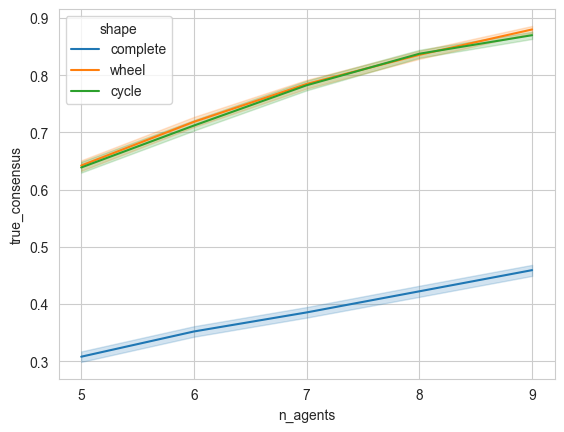

In [6]:
import seaborn as sns
sns.set_style("whitegrid")
ax = sns.lineplot(data=results_df, x="n_agents", y="true_consensus", hue="shape", markers=True, errorbar=("ci", 95))
x_min = df_test["n_agents"].min()
x_max = df_test["n_agents"].max()
ax.set_xticks(range(x_min, x_max+1))

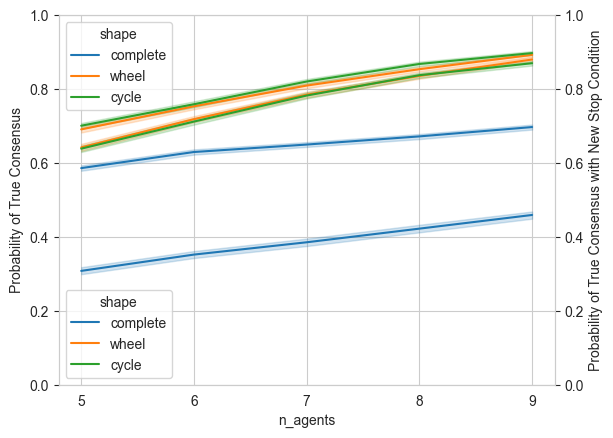

In [7]:
import matplotlib.pyplot as plt
x_min = df_test["n_agents"].min()
x_max = df_test["n_agents"].max()

# plot line chart on axis #1
ax1 = sns.lineplot(
    data=results_df, x="n_agents", y="true_consensus", hue="shape", markers=True, errorbar=("ci", 95)
)
ax1.set_ylabel('Probability of True Consensus')
ax1.set_xticks(range(x_min, x_max+1))
ax1.set_ylim(0, 1)

# set up the 2nd axis
ax2 = ax1.twinx() 

# plot bar chart on axis #2
sns.lineplot(
    data=results_df, x="n_agents", y="true_consensus_prop", hue="shape", markers=True, errorbar=("ci", 95),
    ax = ax2
)
ax2.grid(False) # turn off grid #2
ax2.set_ylabel('Probability of True Consensus with New Stop Condition')
ax2.set_ylim(0, 1)
plt.show()

In [8]:
import pandas as pd
columns = [
        'n_agents',
        'shape',
        'uncertainty',
        'n_experiments',
        "n_simulations",
        "n_steps"
        ]
test_params =[
    [6, "complete", 0.001, 1000, 10**4, 10**8]
]
df_test = pd.DataFrame(data=test_params, columns=columns)
test_result_df = grid_simulations(df_test)

Running simulations: 1it [00:52, 52.85s/it]


In [9]:
print(test_result_df["true_consensus"].mean())


0.61865


## Plotting

### Packages, variables, functions

In [10]:
import pandas as pd
import dill
from pygam import LogisticGAM,LinearGAM, s   
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import opinionated
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use("opinionated_j")
import colormaps as cmaps 

In [2]:
output_dir = "figures"
rename_dict = {
    'n_agents': 'Number of agents',
    'p_rewiring': 'Probability of rewiring',
    'uncertainty': 'Problem easiness',
    'n_experiments': 'Number of experiments',
    'share_of_correct_agents_at_conv': 'Share of correct agents',
    'true_consensus': 'Share of correct agents', # H: added
    'mean_degree': 'Mean degree',
    'average_degree': 'Mean degree',
    'ba_degree':'BA-Degree',
    'convergence_step': 'Steps until convergence (log)',
    'approx_average_clustering_coefficient': 'Clustering coeff.',
    'degree_gini_coefficient': 'Degree Gini coeff.'
    
}

In [4]:
def plot_partial_dependence(gam, hex_colors, feature_names, max_cols=3, filename=None):
    """
    Plots partial dependence plots for all terms in a GAM model with a maximum number of columns,
    centering the last row if it is incomplete.
    
    Parameters:
    gam : object
        The generalized additive model object containing the terms and methods.
    hex_colors : list of str
        List of hex color codes to use for the plots.
    feature_names : list of str
        List of feature names corresponding to the terms in the model.
    max_cols : int
        Maximum number of columns per row in the subplot grid.
    """
    
    term_indices = [i for i, term in enumerate(gam.terms) if not term.isintercept]
    plot_count = len(term_indices)
    nrows = (plot_count + max_cols - 1) // max_cols

    fig = plt.figure(figsize=(5 * max_cols, 5 * nrows))
    m = max_cols
    gs = gridspec.GridSpec(nrows, m * max_cols)
    axs = []

    y_limits = []

    # First pass: compute the y-axis limits for all plots
    for I in term_indices:
        XX = gam.generate_X_grid(term=I)
        pdep, confi = gam.partial_dependence(term=I, X=XX, width=0.99)
        y_limits.append((min(pdep.min(), confi.min()), max(pdep.max(), confi.max())))

    global_y_min = min(limit[0] for limit in y_limits)
    global_y_max = max(limit[1] for limit in y_limits)

    # Create subplots
    for idx, I in enumerate(term_indices):
        row = idx // max_cols
        col = idx % max_cols
        last_row = nrows - 1

        # Apply centering offset only if the last row is incomplete
        if row == last_row and (plot_count % max_cols != 0):
            off = (m * (max_cols - (plot_count % max_cols))) // 2
        else:
            off = 0

        ax = plt.subplot(gs[row, m * col + off: m * (col + 1) + off])
        axs.append(ax)

        XX = gam.generate_X_grid(term=I)
        pdep, confi = gam.partial_dependence(term=I, X=XX, width=0.99)

        ax.plot(XX[:, gam.terms[I].feature], pdep, color=hex_colors[idx % len(hex_colors)])
        ax.plot(XX[:, gam.terms[I].feature], confi, color=hex_colors[idx % len(hex_colors)], ls='--')
        ax.fill_between(XX[:, gam.terms[I].feature], confi[:, 0], confi[:, 1], facecolor=hex_colors[idx % len(hex_colors)], alpha=0.2, interpolate=True)
        ax.set_ylim(global_y_min, global_y_max)
        ax.set_xlabel(feature_names[I])
        if col == 0:
            ax.set_ylabel('Partial Dependence')

    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=300, transparent=True)
    plt.show()
    
    
def plot_scatter_matrix(X, y, max_cols=3, filename=None):
    """
    Plots scatterplots of all columns in DataFrame X against the target vector y,
    with an adjustable number of columns per row and centering if the last row is incomplete.
    
    Parameters:
    X : DataFrame
        Input data with multiple columns.
    y : array-like
        Target variable data.
    max_cols : int
        Maximum number of columns per row in the subplot grid.
    """
    columns = X.columns
    target_name = y.columns[0]
    plot_count = len(columns)
    nrows = (plot_count + max_cols - 1) // max_cols

    fig = plt.figure(figsize=(5 * max_cols, 5 * nrows))
    m = max_cols
    gs = gridspec.GridSpec(nrows, m * max_cols)
    axs = []

    # Create subplots
    for idx, col in enumerate(columns):
        row = idx // max_cols
        col = idx % max_cols
        last_row = nrows - 1

        # Apply centering offset only if the last row is incomplete
        if row == last_row and (plot_count % max_cols != 0):
            off = (m * (max_cols - (plot_count % max_cols))) // 2
        else:
            off = 0

        ax = plt.subplot(gs[row, m * col + off: m * (col + 1) + off])
        axs.append(ax)

        ax.scatter(X.iloc[:, idx], y, c='#ab0b00', alpha=.2)
        ax.set_xlabel(columns[idx])
        if col == 0:
            ax.set_ylabel(target_name)

    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=300, transparent=True)
    plt.show()

In [ ]:
# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6)  ).fit(X_train, y_train)


plot_partial_dependence(gam,['#ab0b00']*6,X.columns,max_cols=3,filename=output_dir + f"perceptron_graph_randomized_partial_dependence_share_corr_agents.png")
print(gam.summary())

### Plotting

### Load data into `data_df`

In [3]:
with open("data/max_cmu_simulation_results.pkl", 'rb') as f:
    data = dill.load(f)

data_df = pd.DataFrame(data)

In [6]:
data_df.head()

,unique_id,n_agents,network_name,uncertainty,n_experiments,average_degree,degree_gini_coefficient,approx_average_clustering_coefficient,diameter,share_of_correct_agents_at_convergence,share_of_correct_agents_at_convergence_alternative_stop,choice_consensus,convergence_step,agent_type,beta,gamma,mean_degree
0,399da41075c94ee0b011b41f933b4ae9,2360,peptic_ulcer,0.003788,49,11.605085,0.561041,0.293519,10,0.911017,0.911017,0.911017,188,beta,NaN,NaN,NaN
1,cb0497e8e1e941189befab509064d158,2360,peptic_ulcer,0.004318,29,11.605085,0.561041,0.293519,10,0.876695,0.876695,0.875847,204,beta,NaN,NaN,NaN
2,fdfea8a8649a42079c856751355dc456,2360,peptic_ulcer,0.001236,48,11.605085,0.561041,0.293519,10,0.675847,0.675847,0.678814,212,beta,NaN,NaN,NaN
3,e6b23a815fa64e34911fa7eba6fc82d7,2360,peptic_ulcer,0.000750,46,11.605085,0.561041,0.293519,10,0.502542,0.502542,0.500424,215,beta,NaN,NaN,NaN
4,08b14d178a6b45e29e7e884e11537faa,2360,peptic_ulcer,0.003556,44,11.605085,0.561041,0.293519,10,0.916949,0.916949,0.915678,220,beta,NaN,NaN,NaN


### GAM partial dependence plots

In [16]:
# data_df['share_of_correct_agents_at_conv'] = data_df['true_consensus']
def plot_gam_dependence(
    df: pd.DataFrame, 
    predictors: list, 
    output: str, 
    output_file: str, 
    show_summary: bool = False
):
    X = df[predictors]
    y = pd.DataFrame(df[output])
    X.rename(columns=rename_dict, inplace=True)
    y.rename(columns=rename_dict, inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42) # HD: X_test and y_test not used?
    spline_term = s(0, n_splines=6)
    for n, _ in enumerate(predictors):
        if n != 0: 
            spline_term = spline_term + s(n, n_splines=6)
    gam = LinearGAM(spline_term).fit(X_train, y_train)
    plot_partial_dependence(
        gam,
        ['#ab0b00']*6,
        X.columns,
        max_cols=3,
        filename=output_file,
    )
    
    if show_summary:
        print(gam.summary())

# X = data_df[['p_rewiring',	'uncertainty',	'n_experiments'	]]
# y = pd.DataFrame(data_df['true_consensus'])

# # Splitting the data into training and testing sets for model validation
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# # Fitting the GAM model
# gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6)).fit(X_train, y_train)


# plot_partial_dependence(
#     gam,
#     ['#ab0b00']*6,
#     X.columns,
#     max_cols=3,
#     filename=output_dir + f"pu_randomized_dependence_plot_accuracy.png")

# print(gam.summary())

C:\Users\heind\AppData\Local\Temp\ipykernel_15728\3515338826.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


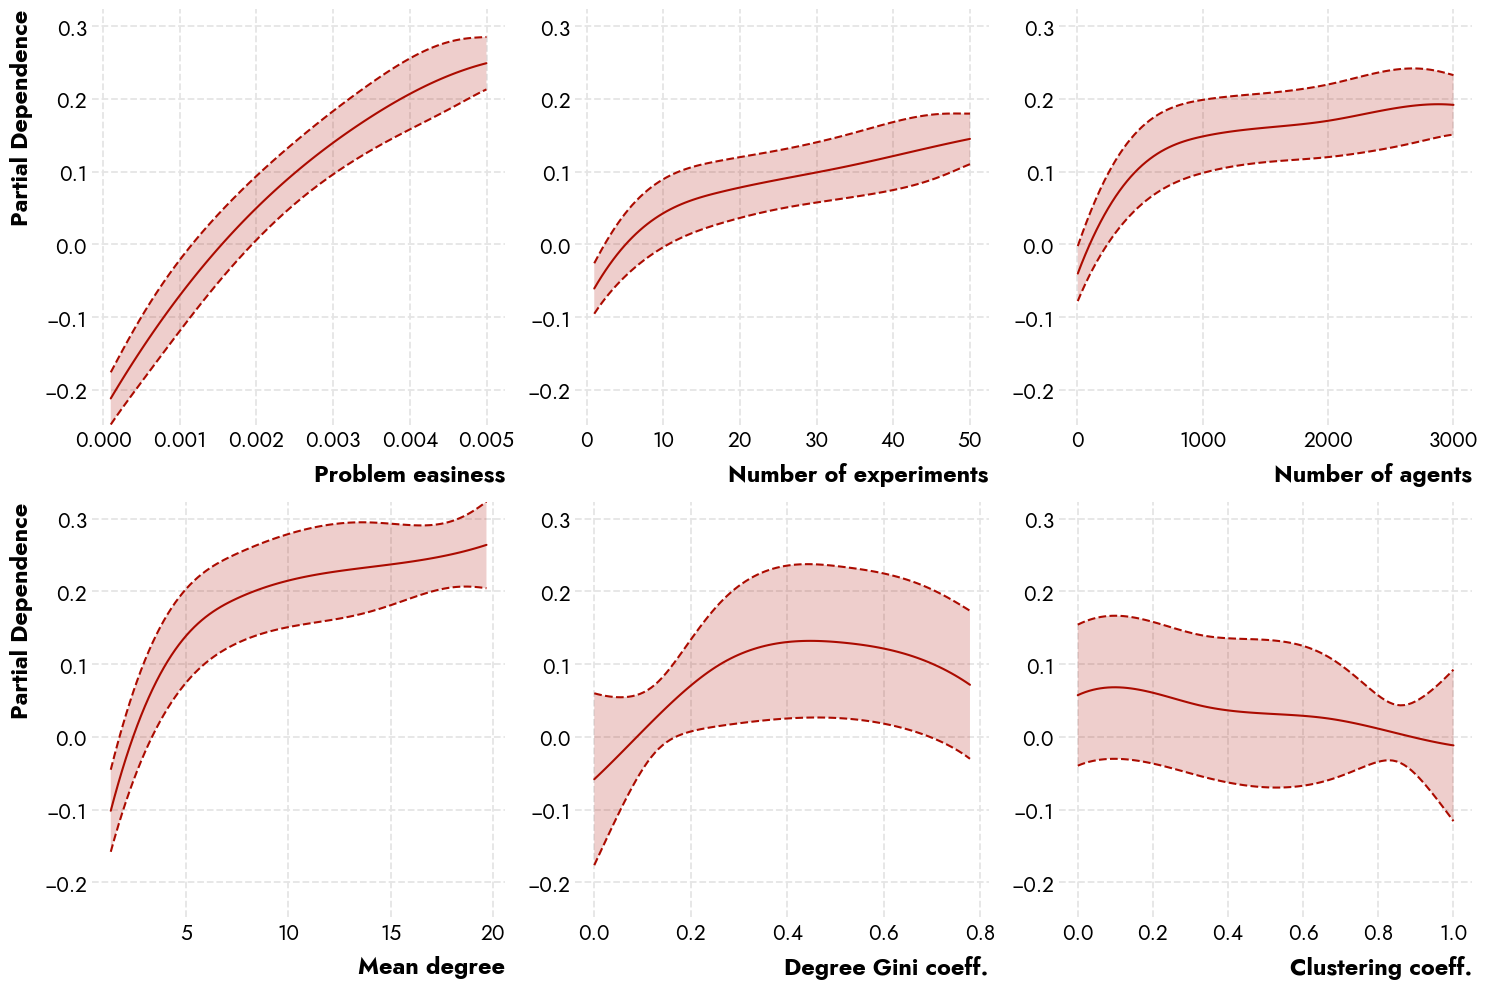

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     23.7905
Link Function:                     IdentityLink Log Likelihood:                               -106687.0394
Number of Samples:                         9900 AIC:                                           213423.6598
                                                AICc:                                          213423.7893
                                                GCV:                                                0.0382
                                                Scale:                                               0.038
                                                Pseudo R-Squared:                                   0.4592
Feature Function                  Lam

C:\Users\heind\AppData\Local\Temp\ipykernel_15728\3515338826.py:28: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [17]:
predictors = [
    'uncertainty',
    'n_experiments',
    'n_agents',
    'average_degree',
    'degree_gini_coefficient',
    'approx_average_clustering_coefficient',
    # 'diameter',
]

plot_gam_dependence(
    data_df, 
    predictors=predictors,
    output='share_of_correct_agents_at_convergence',
    output_file = output_dir + f"pu_randomized_dependence_plot_accuracy.png",
    show_summary=True,
)

In [45]:
def plot_predict(df, predictors, output, gam, hex_colors, feature_names, max_cols=3, filename=None):
    """
    Plots predict plots for all terms in a GAM model with a maximum number of columns,
    centering the last row if it is incomplete.
    
    Parameters:
    gam : object
        The generalized additive model object containing the terms and methods.
    hex_colors : list of str
        List of hex color codes to use for the plots.
    feature_names : list of str
        List of feature names corresponding to the terms in the model.
    max_cols : int
        Maximum number of columns per row in the subplot grid.
    """
    
    term_indices = [i for i, term in enumerate(gam.terms) if not term.isintercept]
    plot_count = len(term_indices)
    nrows = (plot_count + max_cols - 1) // max_cols

    fig = plt.figure(figsize=(5 * max_cols, 5 * nrows))
    m = max_cols
    gs = gridspec.GridSpec(nrows, m * max_cols)
    axs = []

    y_limits = []

    # First pass: compute the y-axis limits for all plots
    for I in term_indices:
        XX = gam.generate_X_grid(term=I)
        pdep, confi = gam.partial_dependence(term=I, X=XX, width=0.99)
        y_limits.append((min(pdep.min(), confi.min()), max(pdep.max(), confi.max())))

    global_y_min = min(limit[0] for limit in y_limits)
    global_y_max = max(limit[1] for limit in y_limits)

    # Create subplots
    for idx, I in enumerate(term_indices):
        predictor = predictors[idx]
        row = idx // max_cols
        col = idx % max_cols
        last_row = nrows - 1

        # Apply centering offset only if the last row is incomplete
        if row == last_row and (plot_count % max_cols != 0):
            off = (m * (max_cols - (plot_count % max_cols))) // 2
        else:
            off = 0

        ax = plt.subplot(gs[row, m * col + off: m * (col + 1) + off])
        axs.append(ax)

        XX = gam.generate_X_grid(term=I)
        ax.plot(XX[:, gam.terms[I].feature], gam.predict(XX), color=hex_colors[idx % len(hex_colors)])
        ax.plot(XX[:, gam.terms[I].feature], gam.prediction_intervals(XX, width=.95), color=hex_colors[idx % len(hex_colors)], ls='--', fillstyle="full")
        ax.scatter(df[predictor], df[output], facecolor='gray', edgecolors='none')
        # pdep, confi = gam.partial_dependence(term=I, X=XX, width=0.99)

        # ax.plot(XX[:, gam.terms[I].feature], pdep, color=hex_colors[idx % len(hex_colors)])
        # ax.plot(XX[:, gam.terms[I].feature], confi, color=hex_colors[idx % len(hex_colors)], ls='--')
        confi = gam.prediction_intervals(XX, width=.95)
        # ax.fill_between(XX[:, gam.terms[I].feature], gam.prediction_intervals(XX, width=.95)[:, 0] gam.prediction_intervals(XX, width=.95)[:, 1], facecolor=hex_colors[idx % len(hex_colors)], alpha=0.2, interpolate=True)
        ax.fill_between(XX[:, gam.terms[I].feature], confi[:, 0], confi[:, 1], facecolor=hex_colors[idx % len(hex_colors)], alpha=0.2, interpolate=True)
        # ax.set_ylim(global_y_min, global_y_max)
        ax.set_xlabel(feature_names[I])
        if col == 0:
            ax.set_ylabel('Partial Dependence')

    # plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=300, transparent=True)
    plt.show()
    
def plot_gam_predict(
    df: pd.DataFrame, 
    predictors: list, 
    output: str, 
    output_file: str, 
    show_summary: bool = False
):
    X = df[predictors]
    y = pd.DataFrame(df[output])
    X.rename(columns=rename_dict, inplace=True)
    y.rename(columns=rename_dict, inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42) # HD: X_test and y_test not used?
    spline_term = s(0, n_splines=6)
    for n, _ in enumerate(predictors):
        if n != 0: 
            spline_term = spline_term + s(n, n_splines=6)
    gam = LinearGAM(spline_term).fit(X_train, y_train)
    
    plot_predict(
        df,
        predictors, 
        output,
        gam,
        ['#ab0b00']*6,
        X.columns,
        max_cols=3,
        filename=output_file,
    )
    
    if show_summary:
        print(gam.summary())

C:\Users\heind\AppData\Local\Temp\ipykernel_15728\418507918.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


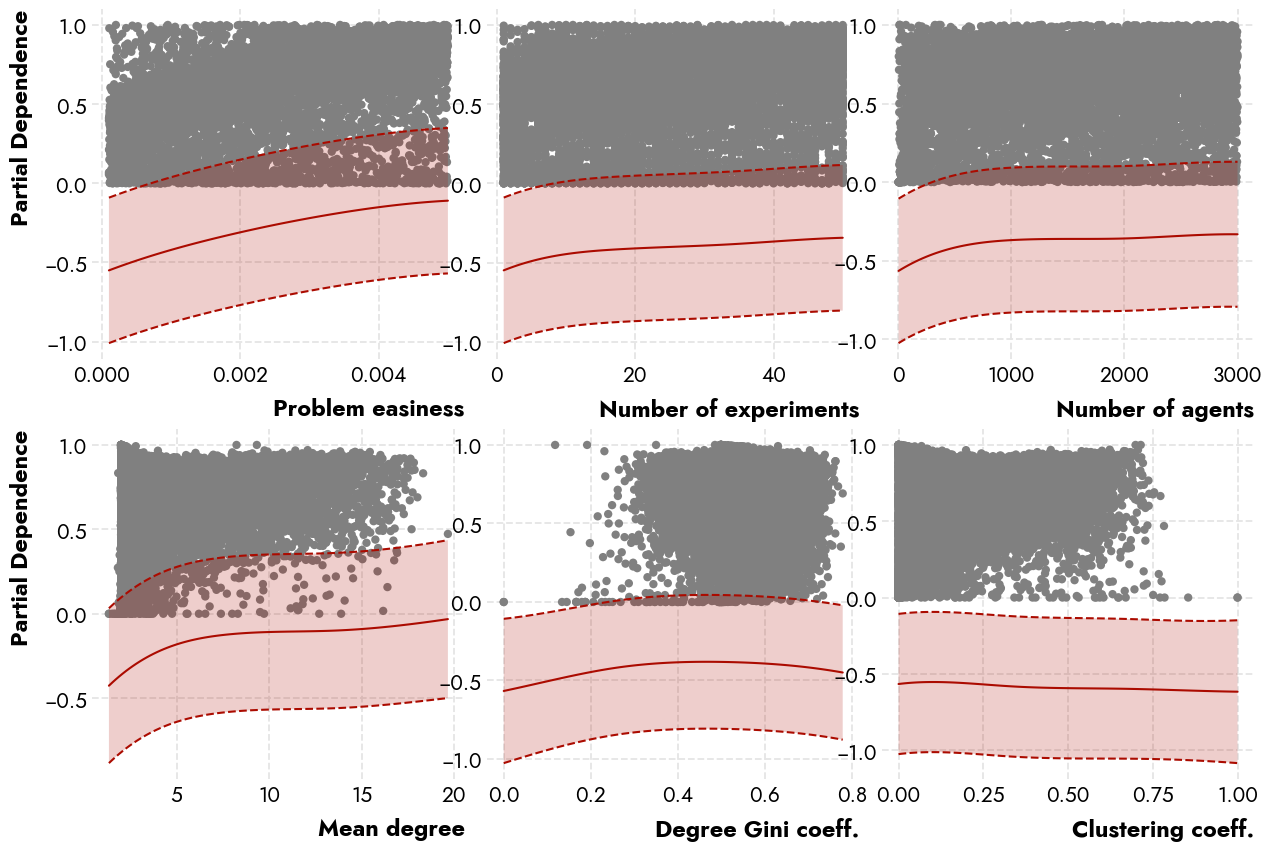

In [46]:
import numpy as np
hyper_graphs_df = data_df[
    (data_df["network_name"] != "peptic_ulcer") & (data_df["network_name"] != "perceptron")
]

plot_gam_predict(
    hyper_graphs_df, 
    predictors=predictors,
    output='share_of_correct_agents_at_convergence',
    output_file = output_dir + f"test.png",
)

C:\Users\heind\AppData\Local\Temp\ipykernel_15728\1470825981.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


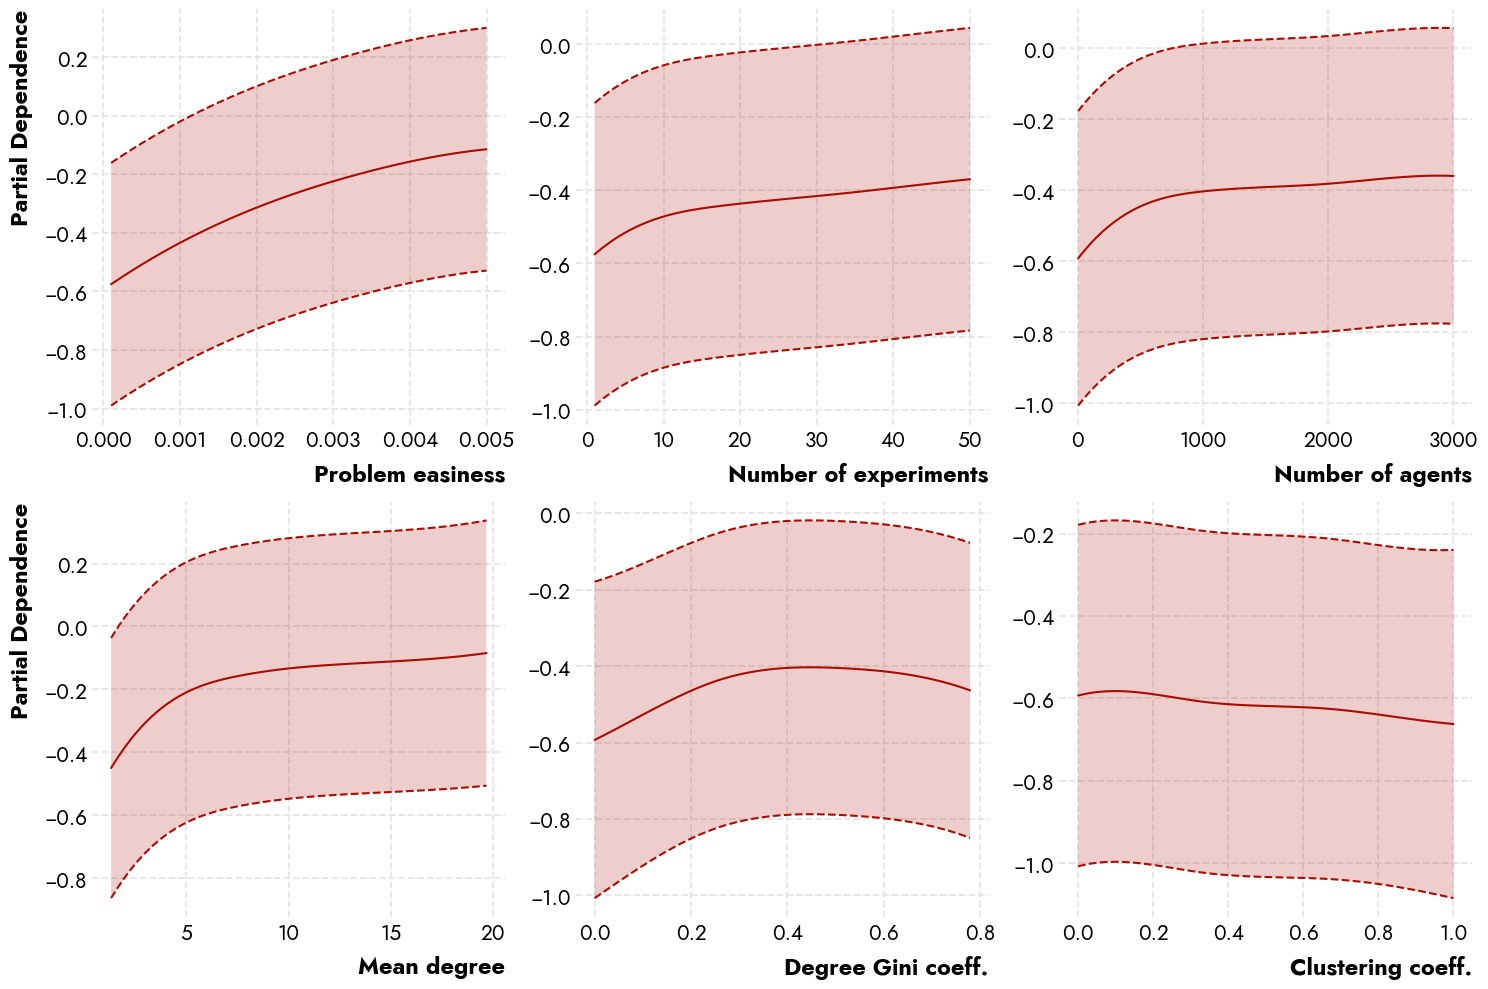

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     23.7905
Link Function:                     IdentityLink Log Likelihood:                               -106687.0394
Number of Samples:                         9900 AIC:                                           213423.6598
                                                AICc:                                          213423.7893
                                                GCV:                                                0.0382
                                                Scale:                                               0.038
                                                Pseudo R-Squared:                                   0.4592
Feature Function                  Lam

C:\Users\heind\AppData\Local\Temp\ipykernel_15728\1470825981.py:100: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [37]:
predictors = [
    'uncertainty',
    'n_experiments',
    'n_agents',
    'average_degree',
    'degree_gini_coefficient',
    'approx_average_clustering_coefficient',
    # 'diameter',
]

plot_gam_predict(
    data_df, 
    predictors=predictors,
    output='share_of_correct_agents_at_convergence',
    output_file = output_dir + f"test.png",
    show_summary=True,
)

### Shapley plots

In [4]:
from matplotlib.colors import ListedColormap
import xgboost as xgb
import shap
from hyperopt import fmin, tpe, hp
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from functools import partial
import numpy as np

In [5]:
class XGBRegressorWithBayesOpt:
    def __init__(self, n_iterations=5, n_points=1, random_state=42, cv=3, scoring='neg_mean_squared_error'):
        self.n_iterations = n_iterations
        self.n_points = n_points
        self.random_state = random_state
        self.cv = cv
        self.scoring = scoring
        self.model = None

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1, random_state=42)

        # Define the hyperparameter space
        space = {
            'n_estimators': hp.quniform('n_estimators', 40, 1500, 1),
            'eta': hp.loguniform('eta', np.log(0.01), np.log(0.5)),
            'max_depth': hp.quniform('max_depth', 3, 30, 1),
            'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
            'subsample': hp.uniform('subsample', 0.5, 1),
            'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
            'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
            'lambda': hp.loguniform('lambda', np.log(1e-8), np.log(1.0)),
            'eval_metric': 'rmse',
            'objective': 'reg:squarederror',
            'nthread': 4,
            'booster': 'gbtree',
            'device': "cuda",
            'seed': 42
        }

        # Define the objective function to minimize
        def objective(params):
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            xgb_model = xgb.XGBRegressor(**params)
            score = -cross_val_score(xgb_model, X_train, y_train, cv=3, scoring="neg_mean_squared_error", n_jobs=-1).mean()
            return {'loss': score, 'status': "ok"}


        tpe_algo = partial(
            tpe.suggest,
            n_startup_jobs=100,  # Number of initial random points
            n_EI_candidates=40, # Number of EI candidates
            gamma=0.2          # Fraction of trials used to model the prior
        )

        # Perform the optimization
        best_params = fmin(objective, space, algo=tpe_algo, max_evals=400,return_argmin=False)
        print("Best set of hyperparameters: ", best_params)
        best_params['max_depth'] = int(best_params['max_depth'])
        best_params['n_estimators'] = int(best_params['n_estimators'])

        self.model = xgb.XGBRegressor(**best_params).fit(X_train, y_train)

    def predict(self, X):
        if self.model:
            return self.model.predict(X)
        else:
            raise Exception("The model is not fitted yet. Please call the fit method before prediction.")

    def score(self, X, y):
        if self.model:
            y_pred = self.predict(X)
            mse = mean_squared_error(y, y_pred)
            r2 = r2_score(y, y_pred)
            return {'MSE': mse, 'R2': r2}
        else:
            raise Exception("The model is not fitted yet. Please call the fit method before scoring.")

In [17]:
def fit_regressor(
    df: pd.DataFrame,
    predictors: list,
    outcome: str,
):
    X = df[predictors]
    y = pd.DataFrame(df[outcome])

    X.rename(columns=rename_dict, inplace=True)
    y.rename(columns=rename_dict, inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.1, 
        random_state=42
    ) # HD: X_test and y_test not used?

    regressor = XGBRegressorWithBayesOpt()
    regressor.fit(X_train, y_train)
    print(f"{r2_score(y_test, regressor.predict(X_test))=}")
    print(f"{mean_squared_error(y_test, regressor.predict(X_test))=}")
    return regressor

def plot_shapley(
    df: pd.DataFrame,
    predictors: list,
    outcome: str,
    output_file: str,
    fitted_regressor: xgb.XGBRegressor = None, 
    # my_regressor = XGBRegressorWithBayesOpt(),    
):
    X = df[predictors]
    y = pd.DataFrame(df[outcome])

    X.rename(columns=rename_dict, inplace=True)
    y.rename(columns=rename_dict, inplace=True)
    
    explainer = shap.TreeExplainer(fitted_regressor.model)
    shap_values = explainer(X)    
    
    
    # 
    df["is_empirical"] = (df['network_name'] != 'sampled').astype(str)
    
    top_inds = np.argsort(-np.sum(np.abs(shap_values.values), 0))

    # Number of top features to plot
    num_top_features = len(predictors)

    # Calculate the number of rows and columns
    max_cols = 4
    nrows = (num_top_features + max_cols - 1) // max_cols

    # Create figure and GridSpec
    fig = plt.figure(figsize=(5 * max_cols, 5 * nrows))
    gs = gridspec.GridSpec(nrows, max_cols ** 2)

    # Calculate the global y-axis limits
    all_shap_values = np.ravel(shap_values.values[:, top_inds[:num_top_features]])
    ymin, ymax = np.min(all_shap_values), np.max(all_shap_values)

    cmap = ListedColormap(['#d9d9d9','#ab0b00'])

    for i in range(num_top_features):
        row = i // max_cols
        col_idx = i % max_cols
        last_row = nrows - 1

        # Apply centering offset only if the last row is incomplete
        if row == last_row and (num_top_features % max_cols != 0):
            off = (max_cols * (max_cols - (num_top_features % max_cols))) // 2
        else:
            off = 0

        ax = plt.subplot(gs[row, max_cols * col_idx + off: max_cols * (col_idx + 1) + off])

        ax.scatter(
            X.values[:, top_inds[i]], 
            shap_values.values[:, top_inds[i]],
            c=df['is_empirical'].map({'True': True, 'False': False}).astype(int), 
            cmap=cmap,
            alpha=.6
        )

        ax.set_ylabel(f'Shapley-Values for {outcome}' if col_idx == 0 else "")
        ax.set_xlabel(X.columns[top_inds[i]])

        # plot x-axis
        ax.axline((0,0), slope=0, color="k")
        
        # Set the same y-axis limits for all plots
        ax.set_ylim([ymin, ymax])

    plt.tight_layout()
    plt.savefig(
        output_file, 
        bbox_inches='tight',
        dpi=400, 
        transparent=True,
    )
    plt.show()

In [19]:
fitted_regressor = fit_regressor(
    data_df,
    ['degree_gini_coefficient', 'approx_average_clustering_coefficient'],
    outcome="share_of_correct_agents_at_convergence",
) 

  0%|          | 0/400 [00:00<?, ?trial/s, best loss=?]

C:\Users\heind\AppData\Local\Temp\ipykernel_27824\3133010230.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


100%|██████████| 400/400 [17:12<00:00,  2.58s/trial, best loss: 0.06369550668007165]   
Best set of hyperparameters:  {'alpha': 0.0004363657193464552, 'booster': 'gbtree', 'colsample_bytree': 0.3176535169308806, 'device': 'cuda', 'eta': 0.12273386566562632, 'eval_metric': 'rmse', 'gamma': 0.4800142903270171, 'lambda': 9.963596430575497e-07, 'max_depth': 15.0, 'min_child_weight': 0.11005660185175746, 'n_estimators': 938.0, 'nthread': 4, 'objective': 'reg:squarederror', 'seed': 42, 'subsample': 0.5862678250690975}


c:\Users\heind\.conda\envs\work\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:35:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\heind\.conda\envs\work\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:35:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


r2_score(y_test, regressor.predict(X_test))=0.09197348356246948
mean_squared_error(y_test, regressor.predict(X_test))=0.05978787141519939


C:\Users\heind\AppData\Local\Temp\ipykernel_27824\3848717924.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


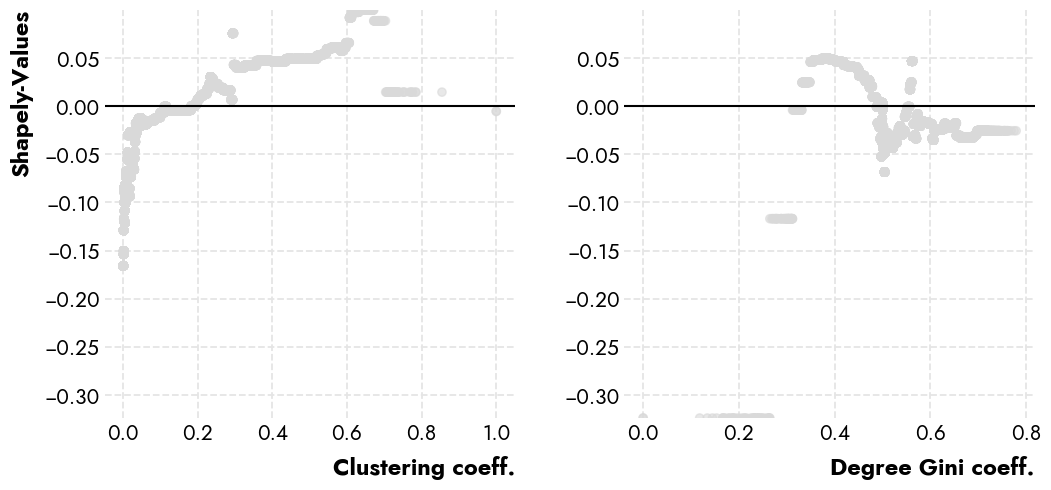

In [15]:
plot_shapley(
    data_df,
    ['degree_gini_coefficient', 'approx_average_clustering_coefficient'],
    outcome="share_of_correct_agents_at_convergence",
    output_file="figures/test_shapley.png",
    fitted_regressor=fitted_regressor,
)


In [89]:
predictors = [
    'n_agents',
    'average_degree',
    'degree_gini_coefficient',
    'approx_average_clustering_coefficient',
    'diameter',
    'n_experiments',
    'uncertainty',
]
outcome="share_of_correct_agents_at_convergence"
output_file = "figures/test_shapley.png"

plot_shapley(
    data_df, 
    predictors,
    outcome,
    output_file    
)

  0%|          | 0/400 [00:00<?, ?trial/s, best loss=?]

C:\Users\heind\AppData\Local\Temp\ipykernel_25268\2462914173.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


 68%|██████▊   | 274/400 [18:55<08:41,  4.14s/trial, best loss: 0.03810601266179964]  


KeyboardInterrupt: 

## Visualize network and degree distribution

In [2]:
import dill
import networkx as nx
# import pygraphviz
from pyvis.network import Network

with open("data_proc/peptic_ulcer_smaller_graph_1900-1978.pkl", 'rb') as f:
    network = dill.load(f)

# pos = nx.nx_agraph.graphviz_layout(network, prog="sfdp")

# nx.draw(network, pos)

# net = Network('500px', '500px', notebook=True, cdn_resources="remote", directed=False)
# net.from_nx(network)
# net.show_buttons(filter_=['physics'])
# net.prep_notebook()
# net.show('figures/test_network.html')

In [3]:
len(network.nodes())

3776

In [1]:
from graph_tool.all import *
import matplotlib
import numpy as np

#g = extract_largest_component(g, directed=False)
pos = sfdp_layout(g)


dprms = dict(fmt="png",  output_size=(1200, 1200))

graph_draw(g, pos, **dprms)

ModuleNotFoundError: No module named 'graph_tool'